In [6]:
import torch as tr

if tr.backends.mps.is_available():
    device = tr.device("mps")
    x = tr.ones(1, device=device)
    print (x)
elif tr.cuda.is_available():
    device = tr.device("cuda")
    x = tr.ones(1, device=device)
    print (x)
else:
    print ("MPS or cuda device not found.")

tensor([1.], device='cuda:0')


In [7]:
from GP import *
import torch as tr
import numpy as np
import matplotlib.pyplot as plt
import statistics as st

import scipy.integrate as integrate
from torch.special import gammaln
#from orthogonal_poly import legendre_01

from torch.autograd.functional import hessian

import scipy.integrate as integrate

import h5py as h5

# import all packages and set plots to be embedded inline
import numpy as np 
from scipy.optimize import minimize 
from scipy import special 
from scipy.optimize import Bounds 
from scipy.linalg import cho_solve 
from pyDOE import lhs 
import time
from sklearn.preprocessing import MinMaxScaler 
from sklearn.pipeline import Pipeline 
import torch as tr
import scipy.special

def get_dist_matelem(z, p, t_min):
    f = 0
    if p <= 3:
        f = h5.File('pdf-data/Nf2+1/ratio.summationLinearFits.cl21_32_64_b6p3_m0p2350_m0p2050.unphased.hdf5','r')
    else:
        f = h5.File('pdf-data/Nf2+1/ratio.summationLinearFits.cl21_32_64_b6p3_m0p2350_m0p2050.phased-d001_2.00.hdf5','r')
    M_z_p = np.array(f['MatElem/bins/Re/mom_0_0_+'+str(p)+'/disp_z+'+str(z)+'/insertion_gt/tsep_'+str(t_min)+'-14'])
    M_0_0 = np.array(f['MatElem/bins/Re/mom_0_0_0/disp_0/insertion_gt/tsep_'+str(t_min)+'-14'])
    M_z_0 = np.array(f['MatElem/bins/Re/mom_0_0_0/disp_z+'+str(z)+'/insertion_gt/tsep_'+str(t_min)+'-14'])
    M_0_p = np.array(f['MatElem/bins/Re/mom_0_0_+'+str(p)+'/disp_0/insertion_gt/tsep_'+str(t_min)+'-14'])
    
    f.close()
    return M_z_p * M_0_0 / M_0_p / M_z_0

def get_final_res(z, p):
    m_4, _ = get_dist_matelem(z, p, 4)
    m_6, s_6 = get_dist_matelem(z, p, 6)
    m_8, s_8 = get_dist_matelem(z, p, 8)
    return m_6, np.sqrt(s_6**2)#+(m_4-m_6)**2)

Np = 6
Nz = 12
Nj = 349
rMj = np.empty([Nj,Np,Nz])
nu = np.empty([Np,Nz])
for p in range(1,Np+1):
    for z in range (1,Nz+1):
        nu[p-1,z-1] = 2.0*np.pi/32.0 *p *z
        #print(p,z,nu[p-1,z-1])
        m_4 = get_dist_matelem(z,p,4)
        m_6 = get_dist_matelem(z,p,6)
        m_8 = get_dist_matelem(z,p,8)
        #expo fit
        m = (m_4*m_8 - m_6**2)/(m_4 + m_8 - 2 * m_6)
        # this fails for certain cases where the denomenator goes too close to zero
        # use the m_6 as default
        rMj[:,p-1,z-1] = m_6
        #Nj=m.shape[0]
        #print(z,p,np.mean(m_4),np.mean(m_6),np.mean(m_8), np.mean(m),np.std(m)*np.sqrt(Nj-1))
rM = np.mean(rMj,axis=0)
rMe = np.std(rMj,axis=0)*np.sqrt(Nj) 
#plot the data
#for i in range(0,6):
#    plt.errorbar(nu[i],rM[i],yerr=rMe[i],fmt='.',alpha=0.5,label='p='+str(i+1))
#plt.legend()
#plt.show()
##integrator
class FE_Integrator:
    def __init__(self,x):
        self.N = x.shape[0]
        xx = np.append(x,2.0*x[self.N-1] - x[self.N-2])
        self.x = np.append(0,xx)
        self.eI = 0

        self.Norm = np.empty(self.N)
        for i in range(self.N):
            self.Norm[i] = self.ComputeI(i, lambda x : 1)
            
    def pulse(self,x,x1,x2):
        return np.heaviside(x-x1,0.5)* np.heaviside(x2-x,0.5)
    
    def f(self,x,i):
 ##       if(i==0):
 ##           R=(x- self.x[2])/(self.x[1] -self.x[2])*np.heaviside(x-self.x[0],1.0)* np.heaviside(self.x[2]-x,0.5)

            #R= self.pulse(x,self.x[0],self.x[1])
            #R= (x- self.x[0])/(self.x[1] -self.x[0])*self.pulse(x,self.x[0],self.x[1])
            #R+=(x- self.x[2])/(self.x[1] -self.x[2])*self.pulse(x,self.x[1],self.x[2])
            #R+=(x- self.x[1])/(self.x[0] -self.x[1])*self.pulse(x,self.x[0],self.x[1]) 
##            return R
        ii=i+1
        R = (x- self.x[ii-1])/(self.x[ii] -self.x[ii-1])*self.pulse(x,self.x[ii-1],self.x[ii  ])
        R+= (x- self.x[ii+1])/(self.x[ii] -self.x[ii+1])*self.pulse(x,self.x[ii  ],self.x[ii+1])

       # if(i==0):
       #     R *=2
        return R
    
    def set_up_integration(self,Kernel = lambda x: 1):
        res = np.empty(self.N)
        for i in range(self.N):
            res[i] = self.ComputeI(i,Kernel)
        return res
   
    # assume symmetrix function F(x,y) = F(y,x)
    # for efficiency
    def set_up_dbl_integration(self,Kernel = lambda x,y: 1):
        res = np.empty([self.N,self.N])
        for i in range(self.N):
            for j in range(i,self.N):
                res[i,j] = self.ComputeIJ(i,j,Kernel)
                res[j,i]  = res[i,j]
        #res[0,:] *=2
        #res[:,0] *=2
        return res
        
    def ComputeI(self,i,Kernel):
        I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,i), self.x[i], self.x[i+2])
        self.eI += eI
        return I
    
    def ComputeIJ(self,i,j,Kernel):
        I,eI = integrate.dblquad(lambda x,y: self.f(x,i)*Kernel(x,y)*self.f(y,j), self.x[j], self.x[j+2],self.x[i], self.x[i+2])
        self.eI += eI
        return I
    
    
# quadratic finite elements are more complicated...
# ... but now it works!
# also I should try the qubic ones too
class FE2_Integrator:
    def __init__(self,x):
        self.N = x.shape[0]
        xx = np.append(x,[2.0*x[self.N-1] - x[self.N-2], 3.0*x[self.N-1]-2*x[self.N-2],0] )
        #self.x = np.append([-x[0],0],xx)
        self.x = np.append(0,xx)
        self.eI = 0

        self.Norm = np.empty(self.N)
        for i in range(self.N):
            self.Norm[i] = self.ComputeI(i, lambda x : 1)
            
    def pulse(self,x,x1,x2):
        return np.heaviside(x-x1,0.5)* np.heaviside(x2-x,0.5)
    
    def f(self,x,i):
        R=0.0
        if(i==0):
            #R=self.pulse(x,self.x[0],self.x[1])
            #R=self.pulse(x,self.x[1],self.x[2])
        #    R+=(x- self.x[2])/(self.x[1] -self.x[2])*self.pulse(x,self.x[1],self.x[2])

            R+=(x- self.x[2])*(x- self.x[3])/((self.x[1] -self.x[3])*(self.x[1] -self.x[2]))**np.heaviside(x-self.x[0],1.0)* np.heaviside(self.x[3]-x,0.5)
            #self.pulse(x,self.x[0],self.x[3])
            return R
        ii =i+1
        if(ii%2==0):
            R  += (x- self.x[ii-1])*(x- self.x[ii+1])/((self.x[ii] -self.x[ii+1])*(self.x[ii] -self.x[ii-1]))*self.pulse(x,self.x[ii-1],self.x[ii+1])
            return R
        else:
            R += (x- self.x[ii-2])*(x- self.x[ii-1])/((self.x[ii] -self.x[ii-2])*(self.x[ii] -self.x[ii-1]))*self.pulse(x,self.x[ii-2],self.x[ii  ])
            R += (x- self.x[ii+1])*(x- self.x[ii+2])/((self.x[ii] -self.x[ii+2])*(self.x[ii] -self.x[ii+1]))*self.pulse(x,self.x[ii  ],self.x[ii+2])
            return R
    
        return R
    
    def set_up_integration(self,Kernel = lambda x: 1):
        res = np.empty(self.N)
        for i in range(self.N):
            res[i] = self.ComputeI(i,Kernel)
        return res
        
    # assume symmetrix function F(x,y) = F(y,x)
    # for efficiency 
    def set_up_dbl_integration(self,Kernel = lambda x,y: 1):
        res = np.empty([self.N,self.N])
        for i in range(self.N):
            for j in range(i,self.N):
                res[i,j] = self.ComputeIJ(i,j,Kernel)
                res[j,i]  = res[i,j]
        return res
    
    def ComputeI(self,i,Kernel):
        #if(i==0):
        #    I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,0), self.x[0], self.x[3])
        #    self.eI += eI
        #    return I
        ii=i+1
        if(ii%2==0):
            I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,i), self.x[ii-1], self.x[ii+1])
            self.eI += eI
        else:
            I,eI = integrate.quad(lambda x: Kernel(x)*self.f(x,i), self.x[ii-2], self.x[ii+2])
            self.eI += eI
        return I
    
    def ComputeIJ(self,i,j,Kernel):
        # I need to fix the i=0 case
        ii=i+1
        jj=j+1
        if(ii%2==0):
            xx = (self.x[ii-1], self.x[ii+1])
        else:
            xx = (self.x[ii-2], self.x[ii+2])
        if(jj%2==0):
            yy = (self.x[jj-1], self.x[jj+1])
        else:
            yy = (self.x[jj-2], self.x[jj+2])
        
        I,eI = integrate.dblquad(lambda x,y: self.f(x,i)*Kernel(x,y)*self.f(y,j), yy[0], yy[1],xx[0], xx[1])
        self.eI += eI

        return I

def interp(x,q,fe):
    S = 0*x
    for k in range(fe.N):
        S+= fe.f(x,k)*q[k]
    return S


#### MODELS ####


class simple_PDF():
    def __init__(self,a,b,g): 
        self.a=a
        self.b=b
        self.g=g
        self.r = 1.0
        self.F = lambda y: (y**a*(1-y)**b*(1 + g*np.sqrt(y)))/self.r
        self.r,e = integrate.quad(self.F,0.0,1.0)  


def DPDFnormed(x,a,b):
    P=tr.tensor([a,b])
    a,b=P[0],P[1]
    dG_da,dG_db=dNorm(P)
    N=tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))
    dP_da=(tr.pow(x,a))*tr.pow(1-x,b)*tr.log(x) *N+dG_da*x**a*(1-x)**b
    dP_db= (tr.pow(x,a))*tr.pow(1-x,b)*tr.log(1-x) *N + dG_db*x**a*(1-x)**b
    return dP_da,dP_db

def Normalization(P):
    a,b=P[0],P[1]
    return tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))

def dNorm(P):
    a,b=P[0],P[1]
    dG_da= tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))*(tr.digamma(a+b+2) - tr.digamma(a+1))
    dG_db= tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))*(tr.digamma(a+b+2) - tr.digamma(b+1))
    return tr.tensor([dG_da,dG_db])


def simplePDFnormed(x,a,b):
    return tr.pow(x,a)*tr.pow(1-x,b)*tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))
#x**a*(1-x)**b*tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))


def very_simplePDFnormed(x,b):
    return (1-x)**b*tr.exp(gammaln(b+2) - gammaln(b+1))

# Posterior GP V2 with split RBF kernel
def pseudo_data(nu,a,b,g,da,db,dg,N):
    sa = np.random.normal(a,da,N)
    sb = np.random.normal(b,db,N)
    sg = np.random.normal(g,dg,N)

    D = np.zeros((N,nu.shape[0]))
    Norm=1.0
    for k in range(N):
        for i in range(nu.shape[0]):
            F =  lambda y: y**sa[k]*(1-y)**sb[k]*(1 + sg[k]*np.sqrt(y)-0.1*y)*np.cos(nu[i]*y) 
            r,e = integrate.quad(F,0.0,1.0) 
            D[k,i] = r
            if i==0:
                Norm = r
            D[k,i] = D[k,i]/Norm
    #add additional gaussian noise to break correlations
    NN = np.random.normal(0,1e-2,np.prod(D.shape)).reshape(D.shape)
    return D+NN

def autograd(func,x):
    x_tensor = x.clone().detach()
    x_tensor.requires_grad_()
    y = func(x_tensor)
    y.backward()
    return x_tensor.grad

def DPDFnormed(x,a,b):
    P=tr.tensor([a,b])
    a,b=P[0],P[1]
    dG_da,dG_db=dNorm(P)
    N=tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))
    dP_da=(tr.pow(x,a))*tr.pow(1-x,b)*tr.log(x) *N+dG_da*x**a*(1-x)**b
    dP_db= (tr.pow(x,a))*tr.pow(1-x,b)*tr.log(1-x) *N + dG_db*x**a*(1-x)**b
    return dP_da,dP_db

def Normalization(P):
    a,b=P[0],P[1]
    return tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))

def dNorm(P):
    a,b=P[0],P[1]
    dG_da= tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))*(tr.digamma(a+b+2) - tr.digamma(a+1))
    dG_db= tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))*(tr.digamma(a+b+2) - tr.digamma(b+1))
    return tr.tensor([dG_da,dG_db])


def simplePDFnormed(x,a,b,N):
    return N*tr.pow(x,a)*tr.pow(1-x,b)*tr.exp(gammaln(a+b+2) - gammaln(a+1) - gammaln(b+1))

#xtensor=tr.tensor(x_grid)
def model(x):
    a=x[0]
    b=x[1]
    xtensor=tr.tensor([0.5])
    return simplePDFnormed(xtensor,a,b)

#### Kernels #####

def KrbfMat(x,s,w):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return s*s*tr.exp(-0.5*((xx - yy)/w)**2)

def Krbf_no_s(x,w):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return tr.exp(-0.5*((xx - yy)/w)**2)


def Krbf1(x,s,w):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    w=10**w
    s=10**s
    return s**2*tr.exp(-0.5*((xx - yy)/w)**2)


class splitRBFker():
    def __init__(self,sp,scale=1):
        self.sp =sp
        self.scale = scale
    def KerMat(self,x,s1,w1,s2,w2):
        K2 = KrbfMat(x,s2,w2) # linear
        K1 = KrbfMat(tr.log(x),s1,w1)
        sig = tr.diag(tr.special.expit(self.scale*(x-self.sp)))
        sigC = tr.eye(x.shape[0])-sig
        ##return K1+K2
        return sigC@K2@sigC + sig@K1@sig

def Sig(x,scale,sp=0.1):
    return tr.special.expit(scale*(x-sp))
def transform(s):
    return s.view(s.shape[1],1).repeat(1,s.shape[1])

#  write the last one as a function
def splitRBFkerMat(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    #plot this values and it looks like a simple rbf kernel
    #s1,w1,s2,w2,scale,sp =  1.0,0.1,1.0,2.2,1.0,.1
    K1 = KrbfMat(x,s1,w1) # linear
    K2 = KrbfMat(tr.log(x+eps),s2,w2) #log
    xx=x.view(1,x.shape[0])
    ss=Sig(xx,scale,sp)
    s=transform(ss)
    #sig=sig.view(1,sig.shape[1]).repeat(sig.shape[1],1)
    sC = 1-s
    return  s*K1*s.T +sC*K2*sC.T

def splitRBF1(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    #plot this values and it looks like a simple rbf kernel
    #s1,w1,s2,w2,scale,sp =  1.0,0.1,1.0,2.2,1.0,.1
    K1 = Krbf1(x,s1,w1) # linear
    K2 = Krbf1(tr.log(x+eps),s2,w2) #log
    xx=x.view(1,x.shape[0])
    ss=Sig(xx,scale,sp)
    s=transform(ss)
    #sig=sig.view(1,sig.shape[1]).repeat(sig.shape[1],1)
    sC = 1-s
    return  s*K1*s.T +sC*K2*sC.T

#DERIVATIVES
def Krbf_ds(x,s,w):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return 2*s*tr.exp(-0.5*((xx - yy)/w)**2)
    #return  2*s*tr.exp(-0.5*((x.view(1,x.shape[0]) - x.view(x.shape[0],1))/w)**2)
def Krbf_dw(x,s,w):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return s*s*tr.exp(-0.5*((xx - yy)/w)**2)*(xx-yy)**2/((w**3))

def sig_ds(x,scale,sp=0.1):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    return sig*(1-sig)

def Kcom_ds1(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    #sigC = 1-sig
    return sig*Krbf_ds(x,s1,w1)*sig.T
def Kcom_dw1(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    #sigC = 1-sig
    return sig*Krbf_dw(x,s1,w1)*sig.T
def Kcom_ds2(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-15):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    sigC = 1-sig
    return sigC*Krbf_ds(tr.log(x+eps),s2,w2)*sigC.T
def Kcom_dw2(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    sig = tr.special.expit(scale*(x.view(1,x.shape[0])-sp))
    sig=sig.view(sig.shape[1],1).repeat(1,sig.shape[1])
    sigC = 1-sig
    return sigC*Krbf_dw(tr.log(x+eps),s2,w2)*sigC.T

def sig_ds(x,scale,sp=0.1):
    return tr.exp(-scale*(x-sp))*(x-sp)*tr.special.expit(scale*(x-sp))**2

def Kcom_ds(x,s1,w1,s2,w2,scale,sp=0.1,eps=1e-12):
    K2=KrbfMat(tr.log(x+eps),s2,w2)
    K1=KrbfMat(x,s1,w1)
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    ##vectors
    ssx=Sig(xx,scale,sp)
    ssy=Sig(yy,scale,sp)
    #transform into matrix
    sx=transform(ssx)
    sy=transform(ssy.T)

    dssx=sig_ds(xx,scale,sp)
    dssy=sig_ds(yy,scale,sp)
    #transform into matrix
    dsx=transform(dssx)
    dsy=transform(dssy.T)

    F1=((-1+sy.T)*dsx + (sx-1)*dsy.T)*K2
    F2=((dsx)*sy.T + sx*(dsy.T))*K1
    return F1+F2

def R(z,t):
    return 1.0/tr.sqrt(1-2*z*t+t*t)

def jacobi(x,s,t,a,b):
   x=x.view(x.shape[0],1)
   y=x.view(1,x.shape[0])
   return (s**2)*(x*y)**a*((1-x)*(1-y))**b*(R(2*x-1,t)*R(2*y-1,t)*((1-t+R(2*x-1,t))*(1-t+R(2*y-1,t)))**a*((1+t+R(2*x-1,t))*(1+t+R(2*y-1,t)))**b)**(-1)#+1e-6*tr.eye(x.shape[0])
   #return s*(x.view(1,x.shape[0])*x.view(x.shape[0],1))**a*((1-x.view(1,x.shape[0]))*(1-x.view(x.shape[0],1)))**b*(R(2*x.view(1,x.shape[0])-1,t)*R(2*x.view(x.shape[0],1)-1,t)*((1-t+R(2*x.view(1,x.shape[0])-1,t))*(1-t+R(2*x.view(x.shape[0],1)-1,t)))**a*((1+t+R(2*x.view(1,x.shape[0])-1,t))*(1+t+R(2*x.view(x.shape[0],1)-1,t)))**b)**(-1)

#plot the trace1
def plothist(trace,mygp1,disc,params="model+kernel+noise",prior=False,burn=100,kernel='jacobi'):
    fig, ax = plt.subplots(trace.shape[1], 1, figsize=(10, 10), sharex=False, sharey=False)

    mygp=mygp1

    i0 = 100
    iF=10000
    if kernel=='jacobi':
        lab=['α', 'β', 'N','s', 't', 'a', 'b','σerror']
        labprior=['α-prior', 'β-prior', 's-prior', 't-prior', 'a-prior', 'b-prior','σerror-prior']
        if params=="kernel":
            lab=lab[mygp.Npd_args:]
            mygp.prior_dist=mygp.prior_dist[mygp.Npd_args:]
        elif params=="kernel+noise":
            lab=lab[mygp.Npd_args:]
            mygp.prior_dist=mygp.prior_dist[mygp.Npd_args:]
        else:
            pass

    elif kernel=='combinedRBF':
        lab=['α','β','N','σ1','w1','σ2','w2','s','σnoise']
        labprior=['α-prior','β-prior','σ1-prior','w1-prior','σ2-prior','w2-prior','s-prior','σerror-prior']
        if params=="kernel":
            lab=lab[mygp.Npd_args:]
            mygp.prior_dist=mygp.prior_dist[mygp.Npd_args:]
        elif params=="kernel+noise":
            lab=lab[mygp.Npd_args:]
            mygp.prior_dist=mygp.prior_dist[mygp.Npd_args:]
        else:
            pass
        
    elif kernel=='RBF':
        lab=['α','β','N','σ','w','σnoise']
        labprior=['α-prior','β-prior','σ-prior','w-prior','σerror-prior']
        if params=="kernel":
            lab=lab[mygp.Npd_args:]
            mygp.prior_dist=mygp.prior_dist[mygp.Npd_args:]
        elif params=="kernel+noise":
            lab=lab[mygp.Npd_args:]
            mygp.prior_dist=mygp.prior_dist[mygp.Npd_args:]
        else:
            pass
    elif kernel=='model':
        lab=['α','β']
        labprior=['α-prior','β-prior']
    else:
        #parameters in greek
        lab=['α','β','γ','δ','ε','ζ','η','θ','ι','κ','λ','μ','ν','ξ','ο','π','ρ','σ','τ','υ','φ','χ','ψ','ω']
        labprior=['α-prior','β-prior','γ-prior','δ-prior','ε-prior','ζ-prior','η-prior','θ-prior','ι-prior','κ-prior','λ-prior','μ-prior','ν-prior','ξ-prior','ο-prior','π-prior','ρ-prior','σ-prior','τ-prior','υ-prior','φ-prior','χ-prior','ψ-prior','ω-prior']

    col=['red','blue','green','pink','black','orange','purple','brown','yellow','cyan','magenta','grey',"lightblue","lightgreen","lightcoral","lightpink","lightyellow","lightcyan","lightmagenta","lightgrey","darkblue","darkgreen","darkcoral","darkpink","darkyellow","darkcyan","darkmagenta","darkgrey"]
    for i in range(trace.shape[1]):
        ax[i].hist(trace[i0:iF,i],bins=disc,label=lab[i],color=col[i],density=True)
        if prior:
            initial=mygp.prior_dist[i].shift
            final=mygp.prior_dist[i].shift+mygp.prior_dist[i].scale
            xxx = tr.linspace(initial,final,1000)
            distexp=mygp.prior_dist[i]
            pdfs=tr.zeros(xxx.shape[0])
            for k in range(xxx.shape[0]):
                pdfs[k]=distexp.pdf(xxx[k])
            ax[i].plot(xxx,pdfs.detach().numpy())
            ax[i].set_xlim([initial-0.5,final+0.5])
        ax[i].legend()
    plt.show()
def plotrace(trace,burn=100,kernel='jacobi'):
    fig, ax = plt.subplots(trace.shape[1],figsize=(20, 8))
    i0 = burn
    iF=trace.shape[0]
    if kernel=='jacobifull':
        lab=['α','β','N','s','t','a','b']
    elif kernel=='rbf':
        lab=['α','β','N','σ','w','σnoise']
    else:
        lab=['α', 'β','N','σ1','w1','σ2','w2','s','σnoise']
    col=['red','blue','green','pink','black','orange','purple','brown','grey',"lightblue","lightgreen","lightcoral","lightpink","lightyellow","lightcyan","lightmagenta","lightgrey","darkblue","darkgreen","darkcoral","darkpink","darkyellow","darkcyan","darkmagenta","darkgrey"]
    for i in range(trace.shape[1]):
        ax[i].plot(trace[i0:iF,i],label=lab[i],color=col[i])
        ax[i].legend()
    plt.show()


def RBF(x,s,w):
    return s*s*tr.exp(-0.5*((x.view(1,x.shape[0]) - x.view(x.shape[0],1))/w)**2)


#from tensor to list
def tensor2list(tensor):
    return [tensor[i].item() for i in range(tensor.shape[0])]

Nx=256
x_grid = np.concatenate((np.logspace(-12,-1,np.int32(Nx/2)),np.linspace(0.1+1e-4,1-1e-12,np.int32(Nx/2))))

#mockdata


#set up input data
def preparedata(i,nu,rMj,rMe,rM,scale="log"):
    #prepare the data
    Nnu = nu.shape[1]
    CovD= np.corrcoef(rMj[:,:,i-1].T)#*(rMj[:,:,i-1].T.shape[0]-1)
    CovD =tr.tensor( (CovD + CovD.T)/2)
    M = rM.T[i]
    eM = rMe.T[i]
    n = nu.T[i]
    Nx=256
    if scale=="lin":
        x_grid = np.linspace(0.0+1e-12,1-1e-12,np.int32(Nx))
    elif scale=="log":
        x_grid = np.concatenate((np.logspace(-12,-1,np.int32(Nx/2)),np.linspace(0.1+1e-4,1-1e-12,np.int32(Nx/2))))
    #x_grid = np.concatenate((np.logspace(-12,-1,np.int32(Nx/2)),np.linspace(0.1+1e-4,1-1e-12,np.int32(Nx/2))))
    fe = FE2_Integrator(x_grid)
    # soften the constrants
    lam = 1e-7  #normalization
    lam_c = 1e-7 #x=1 
    B0 = fe.set_up_integration(Kernel=lambda x: 1)
    B1 = np.zeros_like(B0) 
    B1[-1] = 1.0 # x=1 is at the end...
    n # is the nu values at current z
    B = np.zeros((n.shape[0],Nx))
    for k in np.arange(n.shape[0]):
        B[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(n[k]*x))
    V = np.concatenate((B0[np.newaxis,:],B1[np.newaxis,:],B))
    Gamma = np.zeros((V.shape[0],V.shape[0]))
    Gamma[0,0] = lam
    Gamma[1,1] = lam_c
    Gamma[2:,2:] = CovD
    Y = np.concatenate(([1,0],M))
    return x_grid,V,Y,Gamma

def preparemockdata(Nnupoints):
    #MOCK data
    #######Generate mock data to test the GP

    numock = np.linspace(0,13,Nnupoints)
    #create fake data
    #a,b,c
    jM = pseudo_data(numock,-0.3,2.9,1.0,0.02,.2,0.2,1000)
    #print(jM.shape)
    M = np.mean(jM,axis=0)
    eM = np.std(jM,axis=0)
    """print("Check the zero point:",nu[0],M[0],eM[0])
    plt.errorbar(numock,M,eM,marker='o')
    plt.show()"""
    #chop off the nu = 0
    jM = jM[:,1:]
    n = numock[1:]
    M = np.mean(jM,axis=0)
    eM = np.std(jM,axis=0)

    
    #print("jM shape: ",jM.shape)

    CovD = np.corrcoef(jM.T)   
    CovD =(CovD + CovD.T)/2.0
    """U,S,V = np.linalg.svd(CovD)
    #print("Data Cov: ",CovD)
    print("Data Cov S:",S)
    #plot covD
    plt.imshow(CovD)
    plt.show()"""

    Nx=256
    x_grid = np.concatenate((np.logspace(-12,-1,np.int32(Nx/2)),np.linspace(0.1+1e-4,1-1e-12,np.int32(Nx/2))))
    fe = FE2_Integrator(x_grid)
    lam = 1e-7   # soften the constrants
    lam_c = 1e-7
    B0 = fe.set_up_integration(Kernel=lambda x: 1)
    B1 = np.zeros_like(B0) 
    B1[-1] = 1.0 # x=1 is at the end...
    n # is the nu values at current z
    B = np.zeros((n.shape[0],Nx))
    for k in np.arange(n.shape[0]):
        B[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(n[k]*x))
    V = np.concatenate((B0[np.newaxis,:],B1[np.newaxis,:],B))
    Gamma = np.zeros((V.shape[0],V.shape[0]))
    Gamma[0,0] = lam
    Gamma[1,1] = lam_c
    Gamma[2:,2:] = CovD
    Y = np.concatenate(([1,0],M))
    return x_grid,V,Y,Gamma

### Definition of Del Debbio et al (https://doi.org/10.1140/epjc/s10052-024-13100-1)

In [8]:
def l(x,l0,eps=1e-10):
    return l0*(x+eps)
def Kdebbio(x,l0,sig,eps=1e-13):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return sig**2*tr.sqrt(2*l(xx,l0,eps)*l(yy,l0,eps)/(l(xx,l0,eps)**2+l(yy,l0,eps)**2))*tr.exp(-(xx-yy)**2/(l(xx,l0,eps)**2+l(yy,l0,eps)**2))

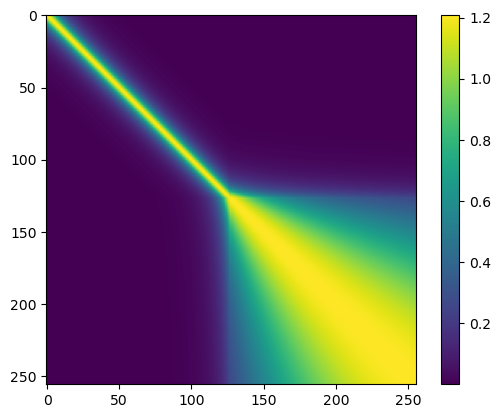

In [9]:
#Type of x_grid
device="cpu"
x_grid=tr.tensor(x_grid,dtype=tr.float32).to(device)
#plot deldebio 
l0=1.1
sig=1.1
Knew=Kdebbio(x_grid,l0,sig)
plt.imshow(Knew.to(device).detach().numpy())
plt.colorbar()
plt.show()

### Modified Kernel

In [10]:
def Kdebbioxa(x,l0,sig,a,eps=1e-13):
    xx=x.view(1,x.shape[0])
    yy=x.view(x.shape[0],1)
    return xx**a*sig**2*tr.sqrt(2*l(xx,l0,eps)*l(yy,l0,eps)/(l(xx,l0,eps)**2+l(yy,l0,eps)**2))*tr.exp(-(xx-yy)**2/(l(xx,l0,eps)**2+l(yy,l0,eps)**2))*yy**a

/local/scr/yacahuanamedra/TMPDIR/ipykernel_401207/2919211475.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_grid=tr.tensor(x_grid,dtype=tr.float32).to(device)


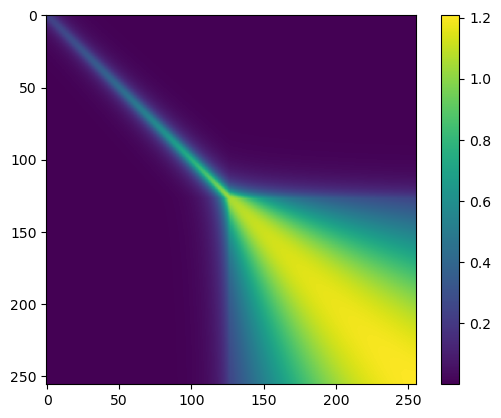

In [11]:
#Type of x_grid
device="cpu"
x_grid=tr.tensor(x_grid,dtype=tr.float32).to(device)
#plot deldebio 
l0=1.1
sig=1.1
Knew=Kdebbioxa(x_grid,l0,sig,0.03)
plt.imshow(Knew.to(device).detach().numpy())
plt.colorbar()
plt.show()

# GP definition 

In [12]:
fits_comb=[]
print("0=gaussian, 1=lognormal, 2=expbeta")
for i in range(0,12):
    x_gri0,V0,Y0,Gamma0 = preparedata(i,nu,rMj,rMe,rM)
    myGP0= GaussianProcess(x_gri0,V0,Y0,Gamma0,f"z={i+1}a",flag="noiseless",device="cpu",Pd=simplePDFnormed, Ker=Kdebbioxa,Pd_args=(0.0,1.0,1.0),Ker_args=(19.0,9.1,-0.5))
    myGP0.prior2ndlevel("all",1000,mean=tr.tensor([-1.0,0.0,0.0,0.0,0.0,-1.0]),sigma=tr.tensor([2.0,6.0,2.0,20.0,10.0,1.0]),prior_mode=tr.tensor([2,2,2,2,2,2]))
    fits_comb.append(myGP0)
    print(fits_comb[i].name, "done")
x_gri0,V0,Y0,Gamma0 = preparemockdata(7)
myGP0= GaussianProcess(x_gri0,V0,Y0,Gamma0,f"z=mock",flag="noiseless",device="cpu",Pd=simplePDFnormed, Ker=Kdebbioxa,Pd_args=(-0.0,1.0,1.0),Ker_args=(19.0,9.1,-0.5))
myGP0.prior2ndlevel("all",1000,mean=tr.tensor([-1.0,0.0,0.0,0.0,0.0,-1.0]),sigma=tr.tensor([2.0,6.0,2.0,20.0,10.0,1.0]),prior_mode=tr.tensor([2,2,2,2,2,2]))
fits_comb.append(myGP0)
print(fits_comb[-1].name, "done")

0=gaussian, 1=lognormal, 2=expbeta


/sciclone/pscr/yacahuanamedra/GP.py:739: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.shift=tr.tensor(shift).to(device)
/sciclone/pscr/yacahuanamedra/GP.py:740: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.scale=tr.tensor(scale).to(device)


z=1a done
z=2a done
z=3a done
z=4a done
z=5a done
z=6a done
z=7a done
z=8a done
z=9a done
z=10a done
z=11a done
z=12a done
z=mock done


In [ ]:
fits_comb=[]
print("0=gaussian, 1=lognormal, 2=expbeta")
for i in range(0,12):
    x_gri0,V0,Y0,Gamma0 = preparedata(i,nu,rMj,rMe,rM)
    myGP0= GaussianProcess(x_gri0,V0,Y0,Gamma0,f"z={i+1}a",flag="noiseless",device="cpu",Pd=simplePDFnormed, Ker=Kdebbio,Pd_args=(0.0,1.0,1.5),Ker_args=(19.0,9.0))
    myGP0.prior2ndlevel("all",1000,mean=tr.tensor([-1.0,0.0,0.0,0.0,0.0]),sigma=tr.tensor([2.0,6.0,2.0,20.0,10.0]),prior_mode=tr.tensor([2,2,2,2,2]))
    fits_comb.append(myGP0)
    print(fits_comb[i].name, "done")
x_gri0,V0,Y0,Gamma0 = preparemockdata(7)
myGP0= GaussianProcess(x_gri0,V0,Y0,Gamma0,f"z=mock",flag="noiseless",device="cpu",Pd=simplePDFnormed, Ker=Kdebbio,Pd_args=(-0.0,1.0,1.5),Ker_args=(19.0,9.0))
myGP0.prior2ndlevel("all",1000,mean=tr.tensor([-1.0,0.0,0.0,0.0,0.0]),sigma=tr.tensor([2.0,6.0,2.0,20.0,10.0]),prior_mode=tr.tensor([2,2,2,2,2]))
fits_comb.append(myGP0)
print(fits_comb[-1].name, "done")

0=gaussian, 1=lognormal, 2=expbeta
z=1a done
z=2a done
z=3a done
z=4a done
z=5a done
z=6a done
z=7a done
z=8a done
z=9a done
z=10a done
z=11a done
z=12a done
z=mock done


In [47]:
start=time.time()
mode='all'
Ntrain=2000
function="evidence"
for i in range(0,13):
    if i in [123]:
        fits_comb[i].train(Ntrain,lr=1e-2,mode=mode,function=function)
    elif i in [19]:
        fits_comb[i].train(Ntrain,lr=1e-2,mode=mode,function=function)
    else:
        fits_comb[i].train(Ntrain,lr=1e-2,mode=mode,function=function)
    print(tr.tensor(fits_comb[i].pd_args +fits_comb[i].ker_args  + (fits_comb[i].sig,)))
end=time.time()
print(mode,function)
print("time",end-start)

Training everything z=1a
tensor([-0.4414,  1.9863,  1.0000, 25.4552, -0.4040,  3.3704,  1.0000])
Training everything z=2a
tensor([-0.5223,  1.6035,  1.0000, 24.9995,  0.1866,  3.3536,  1.0000])
Training everything z=3a
tensor([-0.3980,  1.8611,  0.9909, 24.4830,  0.5201,  2.9830,  1.0000])
Training everything z=4a
tensor([-0.8125,  0.1453,  0.9936, 23.9769, -0.3743,  2.4368,  1.0000])
Training everything z=5a
tensor([-0.1328,  2.0863,  1.0401, 22.5273, -0.3436,  0.8520,  1.0000])
Training everything z=6a
tensor([ 0.1752,  3.1311,  1.0000, 24.3206,  0.3463,  3.1347,  1.0000])
Training everything z=7a
tensor([ 0.4365,  3.8758,  1.0000, 24.3365,  0.1876,  3.2452,  1.0000])
Training everything z=8a
tensor([ 0.6398,  4.4789,  1.0000, 24.3198,  0.0780,  3.2002,  1.0000])
Training everything z=9a
tensor([ 0.6896,  4.8245,  0.9500, 22.0582,  0.3215,  0.6137,  1.0000])
Training everything z=10a
tensor([ 0.6088,  4.3648,  0.9901, 23.7224, -0.4645,  2.5181,  1.0000])
Training everything z=11a
ten

In [ ]:
col=['red','blue','green','pink','black','orange','purple','brown','cyan','magenta','yellow','grey','lime']
fe = FE2_Integrator(x_grid)
nn = np.linspace(0,20,128)
iB = np.zeros((nn.shape[0],Nx))
for k in range(nn.shape[0]):
    iB[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(nn[k]*x))

/local/scr/yacahuanamedra/TMPDIR/ipykernel_404595/4172442435.py:13: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  pdfMc= np.random.multivariate_normal(p,Cp,(100,))


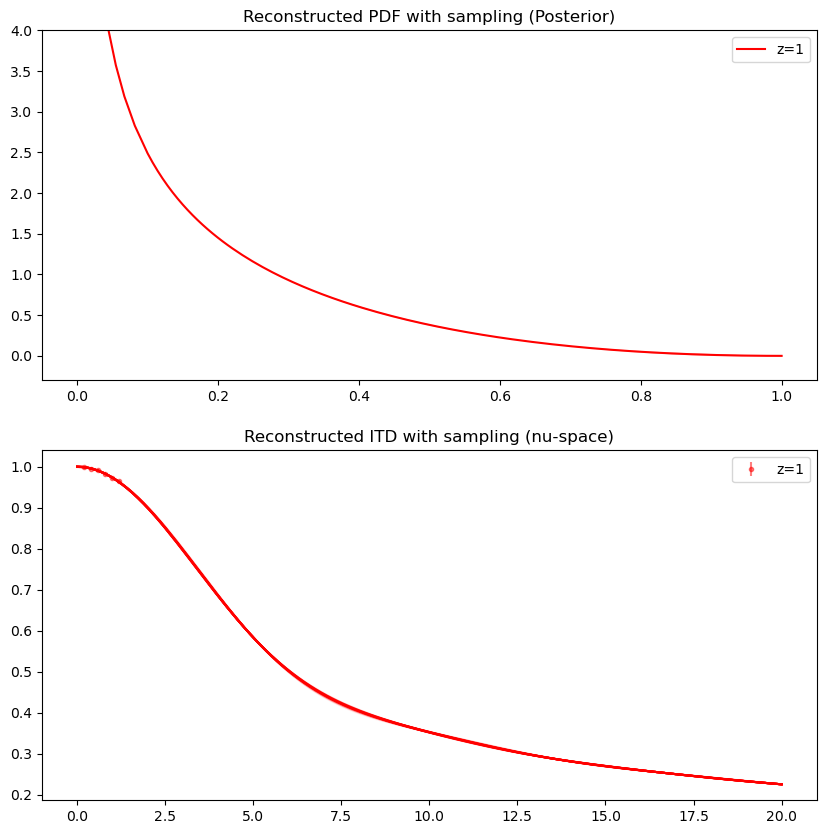

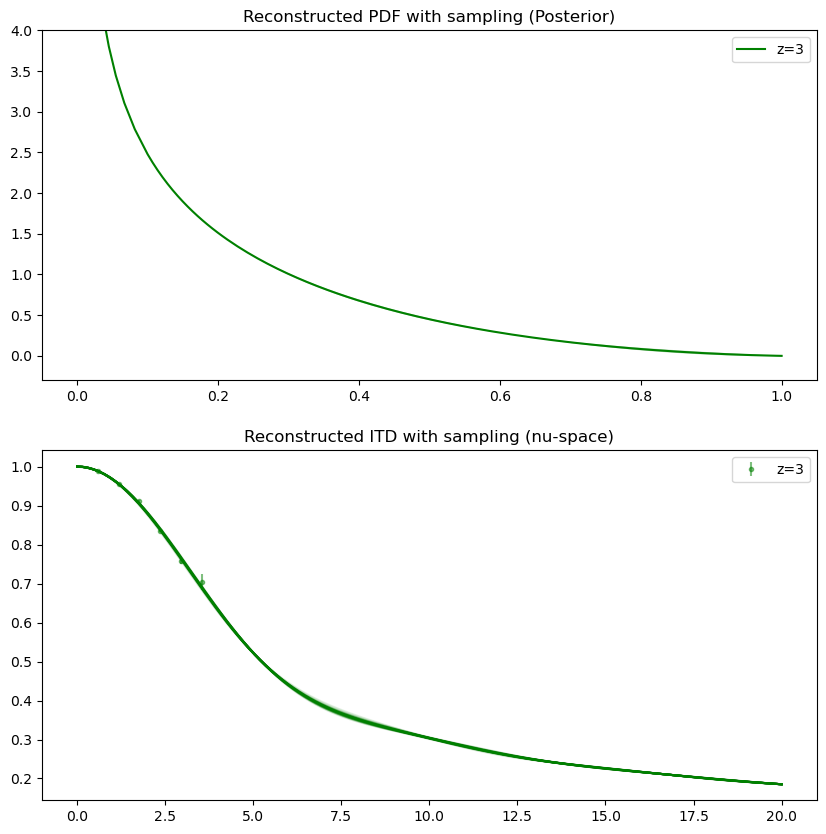

/local/scr/yacahuanamedra/TMPDIR/ipykernel_404595/4172442435.py:18: RuntimeWarning: invalid value encountered in sqrt
  perror=1.96*np.diag(Cp)**(0.5)


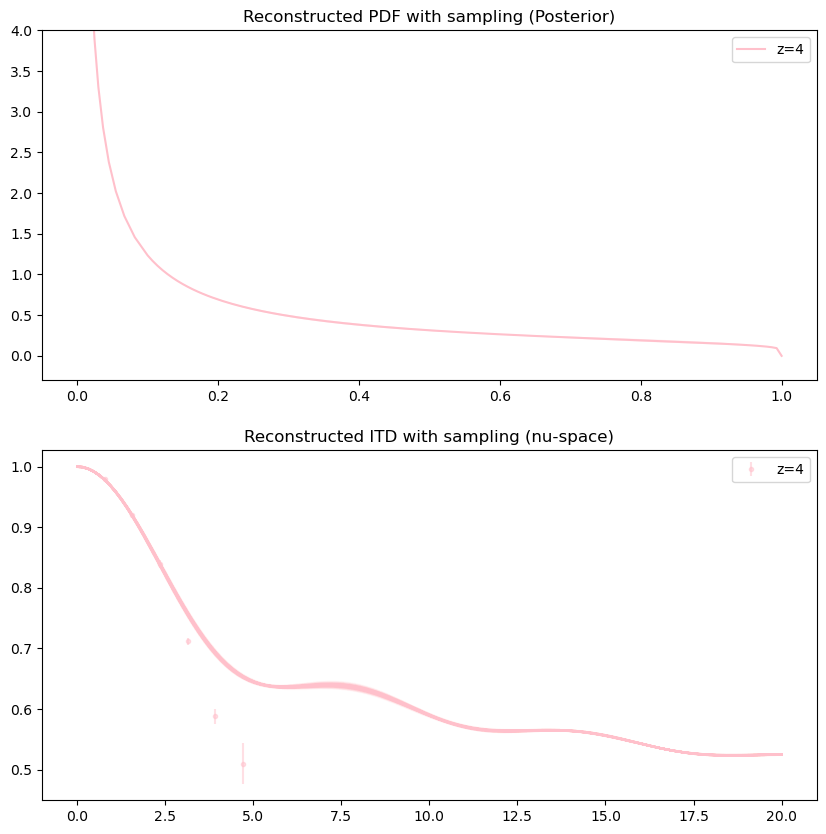

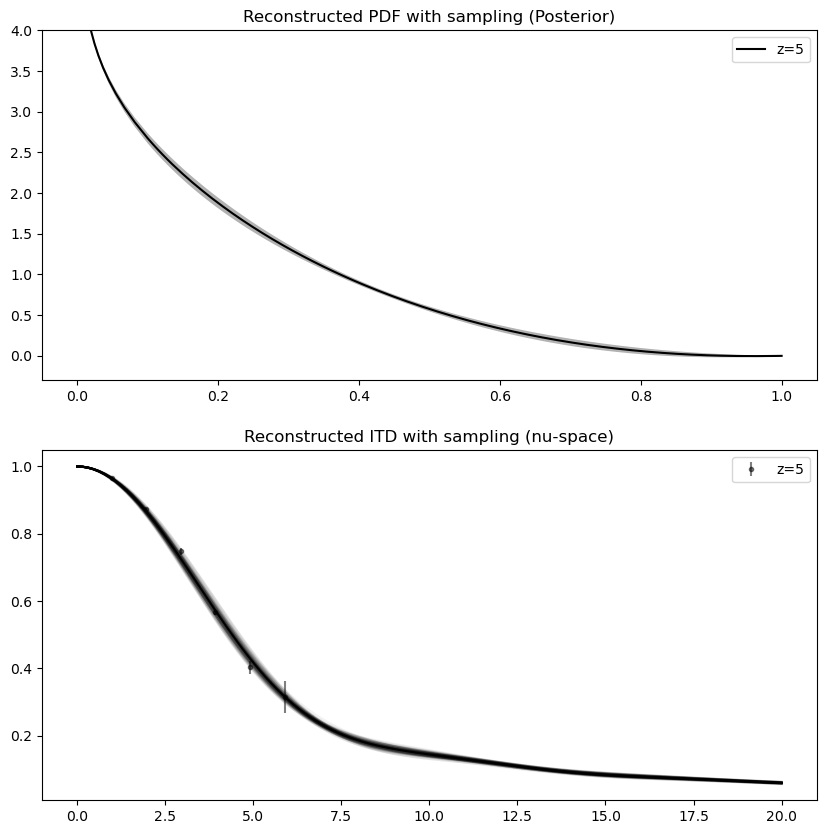

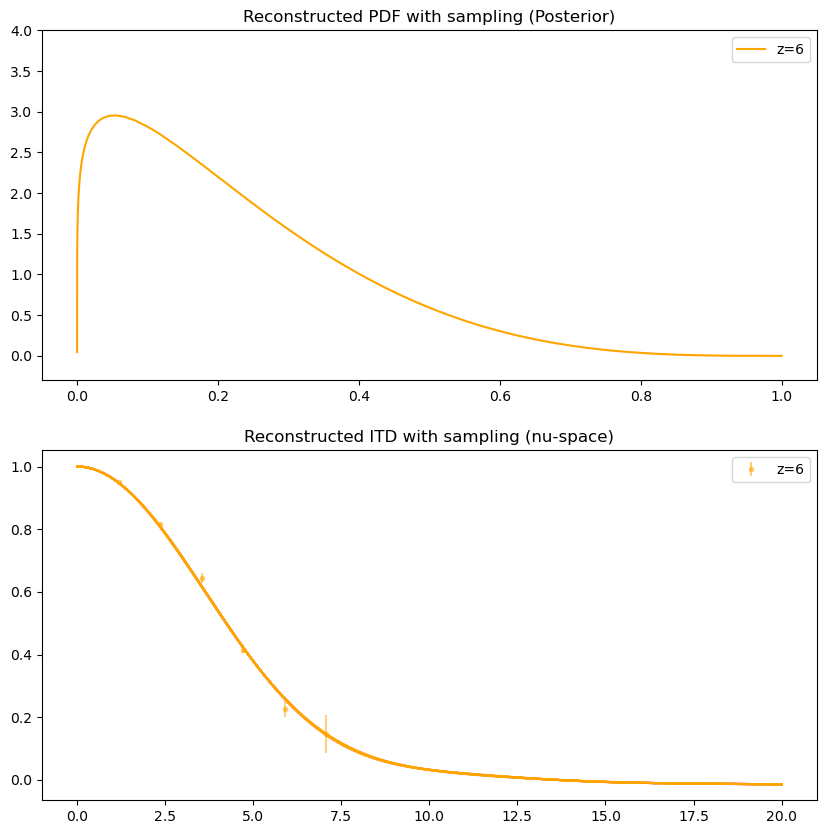

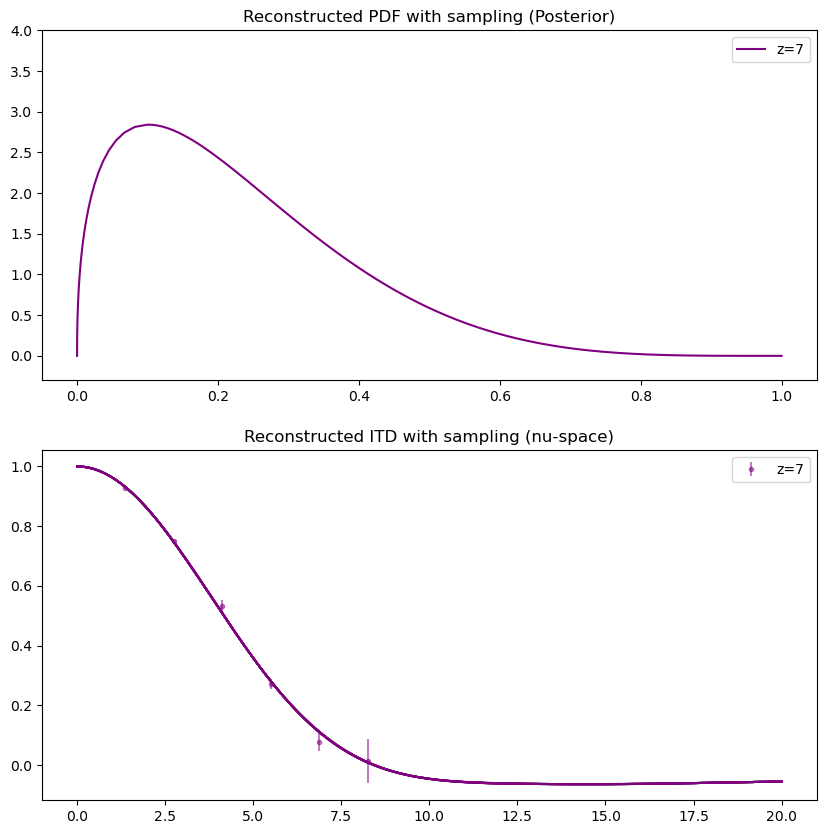

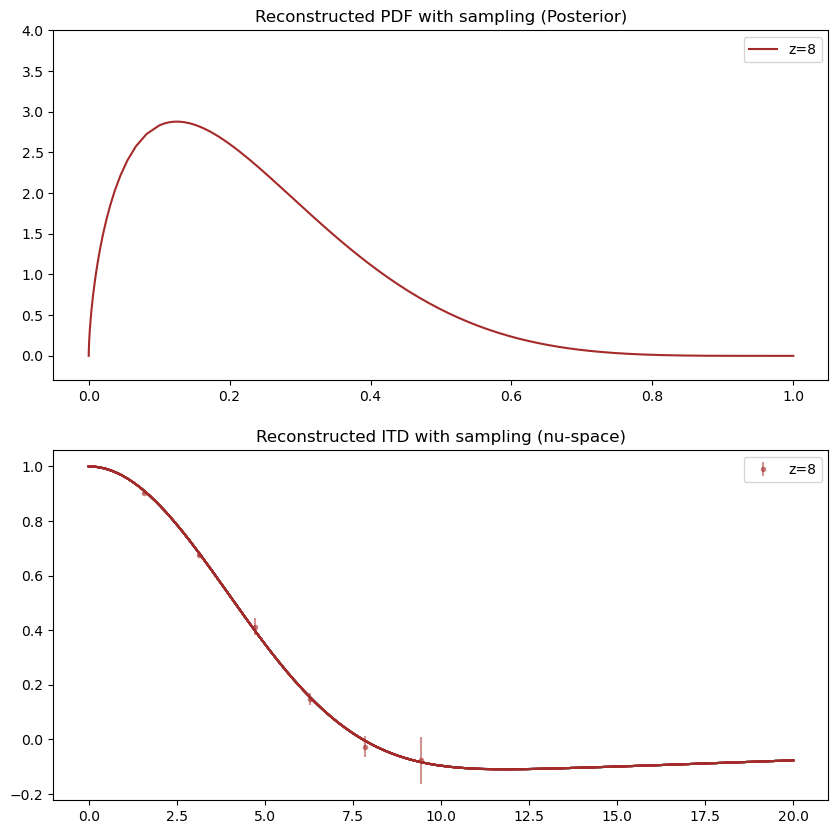

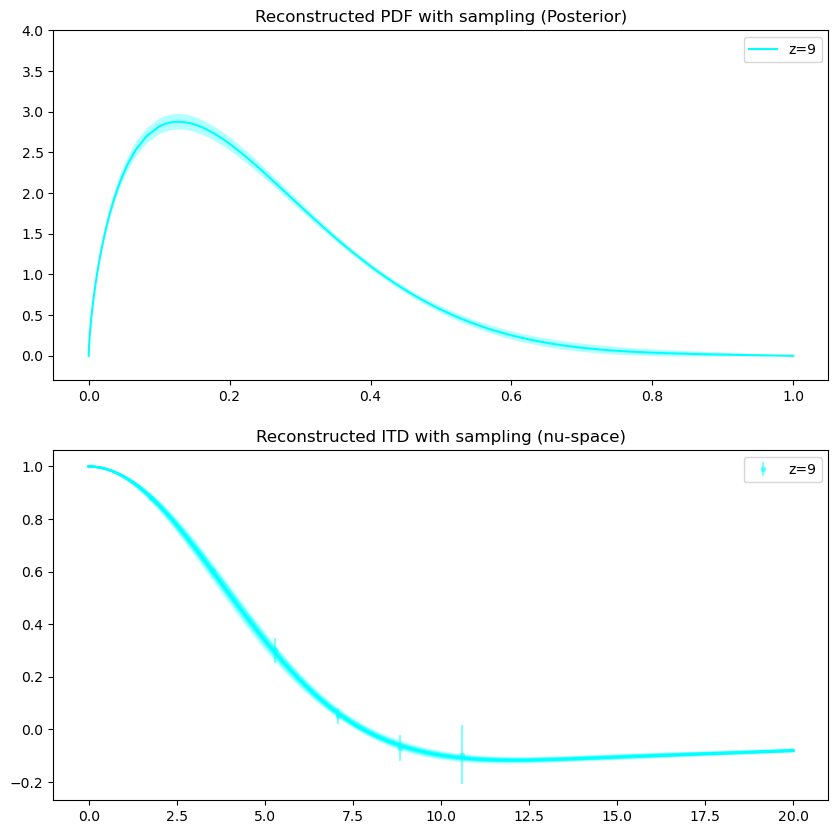

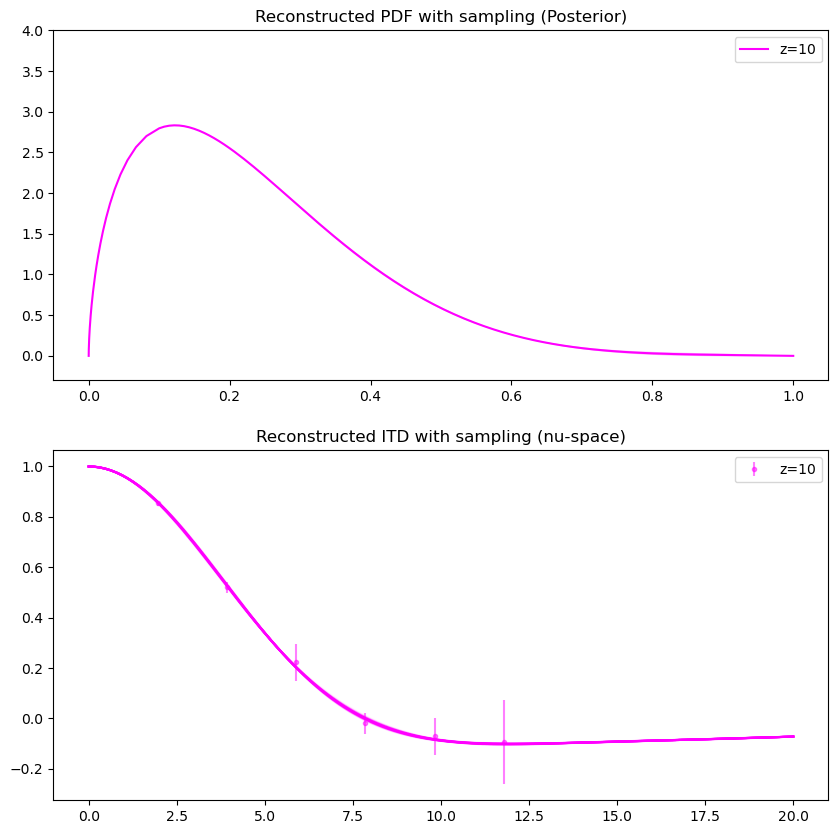

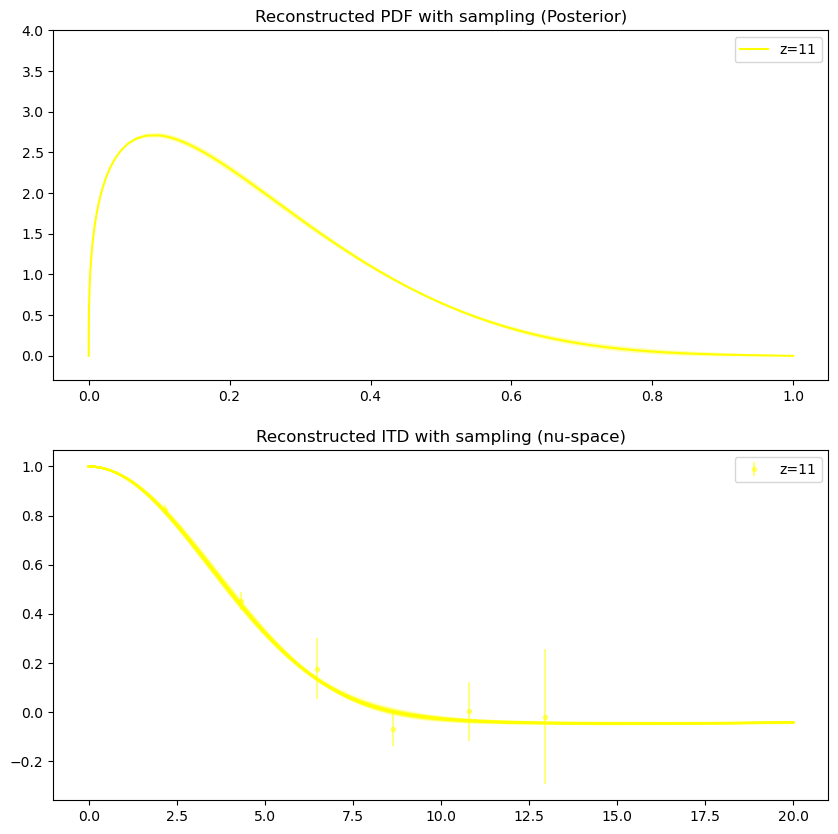

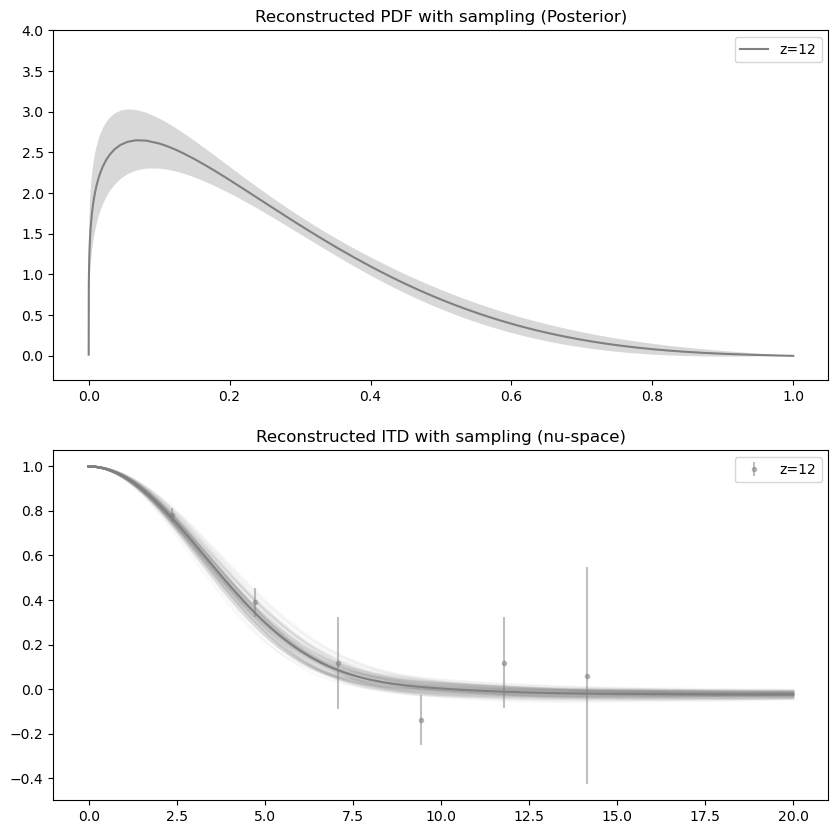

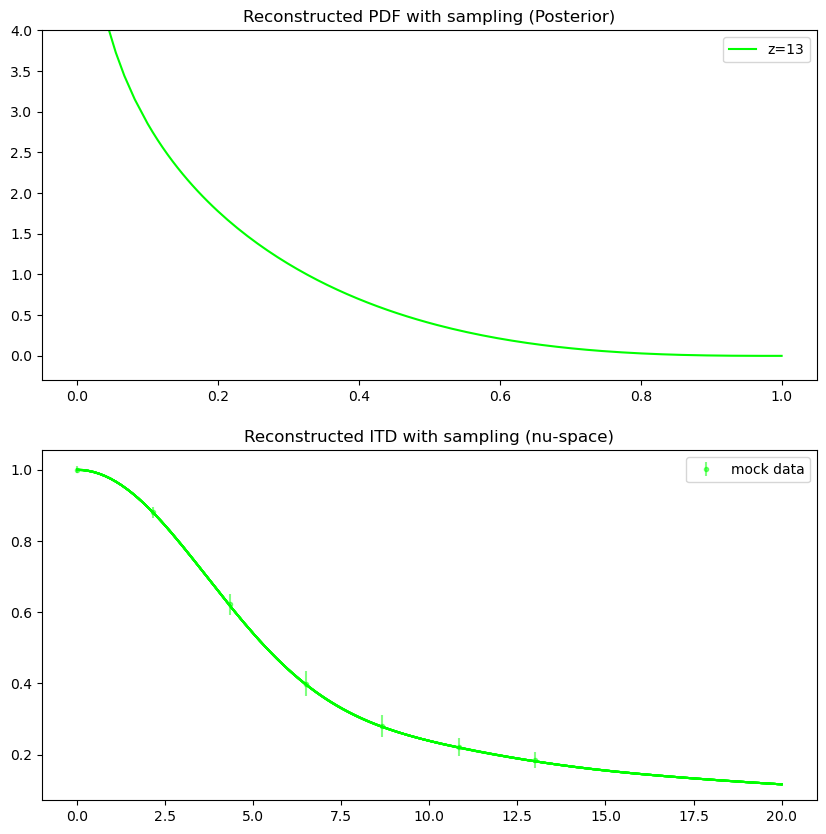

In [48]:
for i in range(0,13):
    if i in [1]:
        continue
    else:
        fig, ax= plt.subplots(2,figsize=(10, 10))
        ax[0].set_title("Reconstructed PDF with sampling (Posterior)")
        ax[1].set_title("Reconstructed ITD with sampling (nu-space)")
        fe = FE2_Integrator(x_grid)
        p,Cp = fits_comb[i].ComputePosterior()
        p,Cp = p.to("cpu"),Cp.to("cpu")
        Cp = 0.5*(Cp+Cp.T) #+1e-8*tr.eye(Cp.shape[0])
        #Mc=tr.distributions.MultivariateNormal(p,covariance_matrix=Cp)
        pdfMc= np.random.multivariate_normal(p,Cp,(100,))
        #plot the data
        #pdfMc = Mc.sample((100,))
        #ax[0].plot(x_grid,pdfMc.T,alpha=0.1,color=col[i])
        ax[0].plot(x_grid,p,label='z='+str(i+1),color=col[i])
        perror=1.96*np.diag(Cp)**(0.5)
        #p=fits_comb[i].Pd(fits_comb[i].x_grid.cpu(),*fits_comb[i].pd_args).numpy()
        ax[0].fill_between(x_grid, p - perror, p + perror, facecolor=col[i], alpha=0.3)
        
        ax[0].legend()
        ax[0].set_ylim([-0.3,4])
        #ax[0].ylim([-0.1,4])
        ttQ = pdfMc@iB.T
        mttQ = ttQ.mean(axis=0)
        ax[1].plot(nn,ttQ.T,color=col[i],alpha=0.05)
        ax[1].plot(nn,mttQ,color=col[i])
        if i ==12:
            numock = np.linspace(0,13,7)
            jM = pseudo_data(numock,-0.3,2.9,1.0,0.02,.2,0.2,1000)
            M = np.mean(jM,axis=0)
            eM = np.std(jM,axis=0)
            plt.errorbar(numock,M,eM,fmt='.',alpha=0.5,label='mock data',color=col[i])
        else:
            plt.errorbar(nu.T[i],rM.T[i],yerr=rMe.T[i],fmt='.',alpha=0.5,label='z='+str(i+1),color=col[i])
        plt.legend()
        plt.show()

For some case del Debio kernel overfits

In [17]:
##sample all the parameters
momentum=1*tr.tensor([1.0,1.0,1.0,1.0,1.0,1.0])
sigma=tr.tensor([3.0,5.0,6.0,5.0,6.0,5.0,5.5,2.0])
samplers=[]
for i in range(0,13):

    GPsampler=HMC_sampler(fits_comb[i].nlogpost2levelpdf,device="cpu",diagonal=1.0*momentum,grad=None)

    GPsampler.q0=tr.tensor(fits_comb[i].pd_args + fits_comb[i].ker_args).to("cpu")

    samplers.append(GPsampler)
    print(fits_comb[i].name,"sampler done")

z=1a sampler done
z=2a sampler done
z=3a sampler done
z=4a sampler done
z=5a sampler done
z=6a sampler done
z=7a sampler done
z=8a sampler done
z=9a sampler done
z=10a sampler done
z=11a sampler done
z=12a sampler done
z=mock sampler done


In [18]:
i=3
start=time.time()
traceq,tracep,traceH=samplers[i].sample(samplers[i].q0,1000,1.0/500,50)
end=time.time()
print("time",end-start)

100%|█████████████████████████████████████████████████| 999/999 [06:05<00:00,  2.73it/s]
time 365.3679897785187


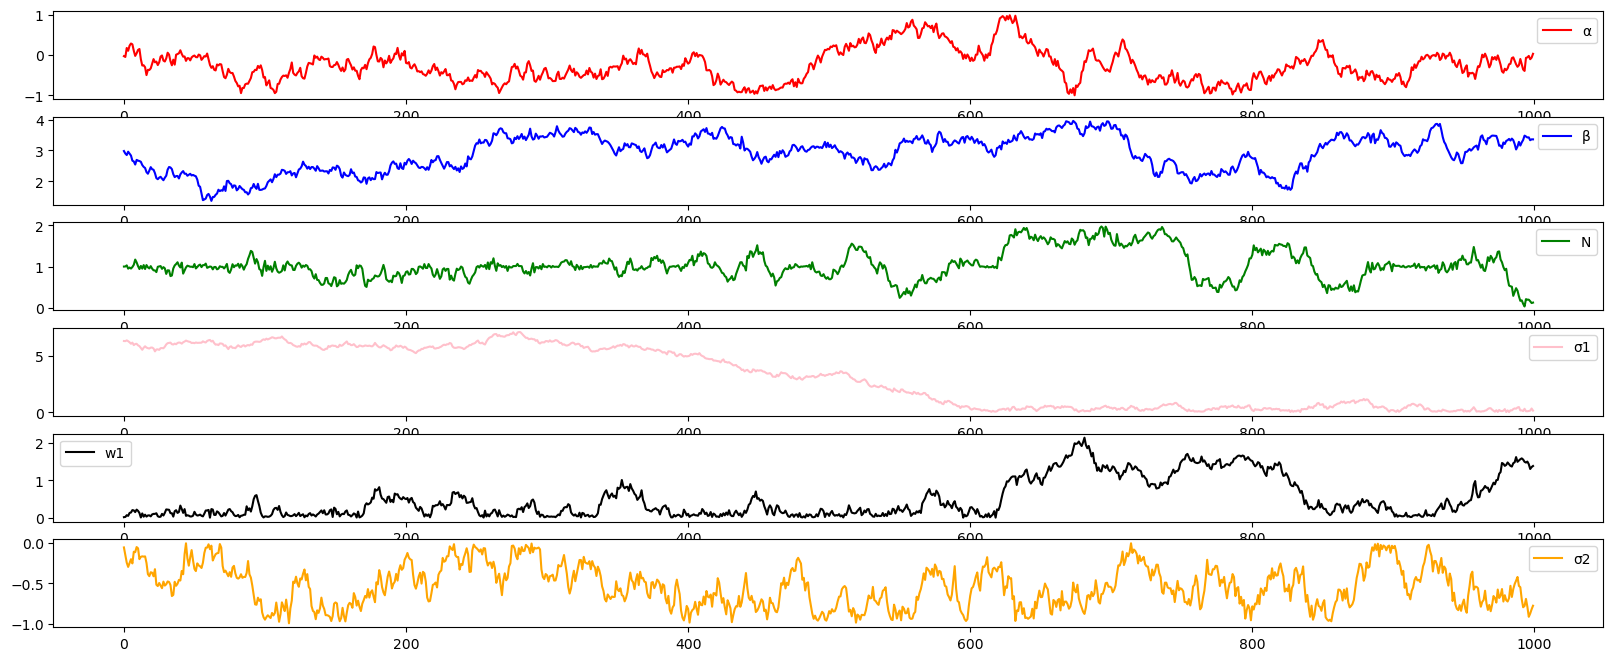

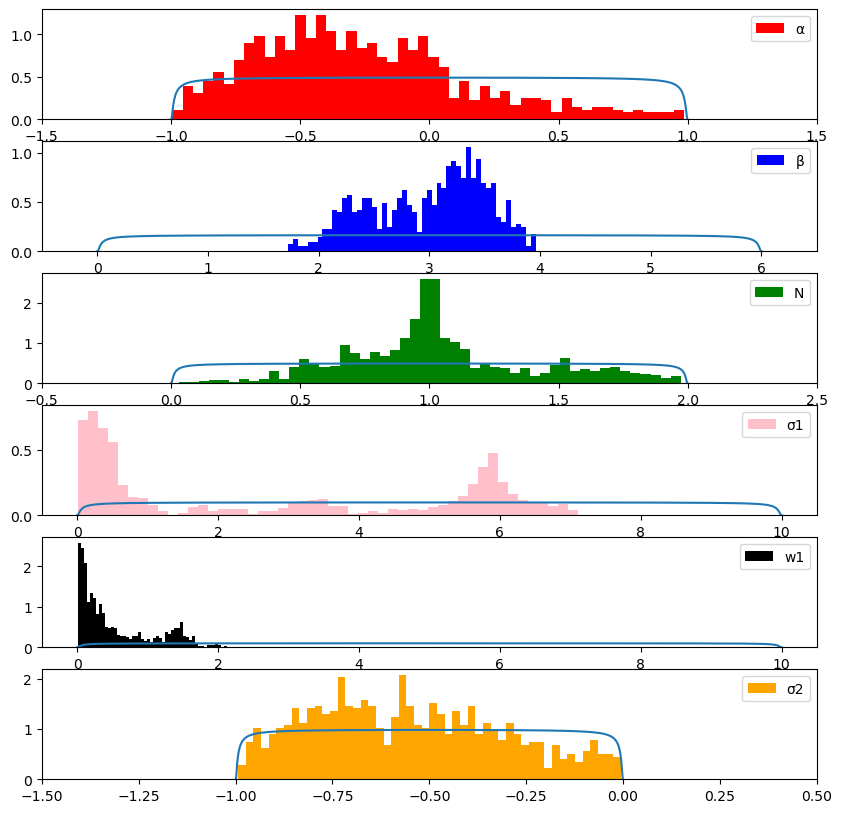

In [19]:
plotrace(traceq[0:10000].cpu(),0,kernel='splitrbf')
plothist(traceq[0:10000],fits_comb[i],50,prior=True,burn=0,kernel='combinedRBF')

## Load Data

In [8]:
traces=[]
for i in range(0,13):
    trace=tr.load('KDebbio(%s).pt' %(fits_comb[i].name))
    traces.append(trace)

/local/scr/yacahuanamedra/TMPDIR/ipykernel_404595/53404908.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trace=tr.load('KDebbio(%s).pt' %(fits_comb[i].name))


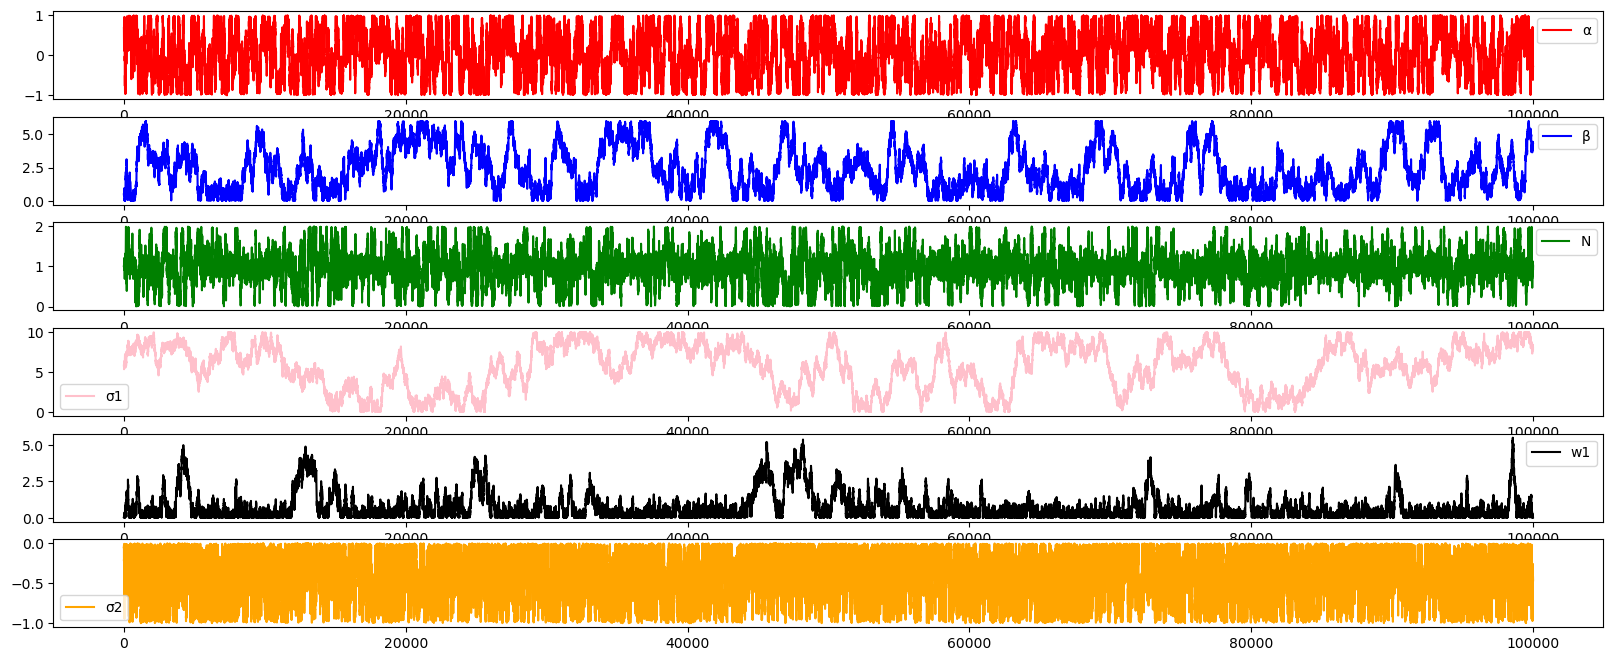

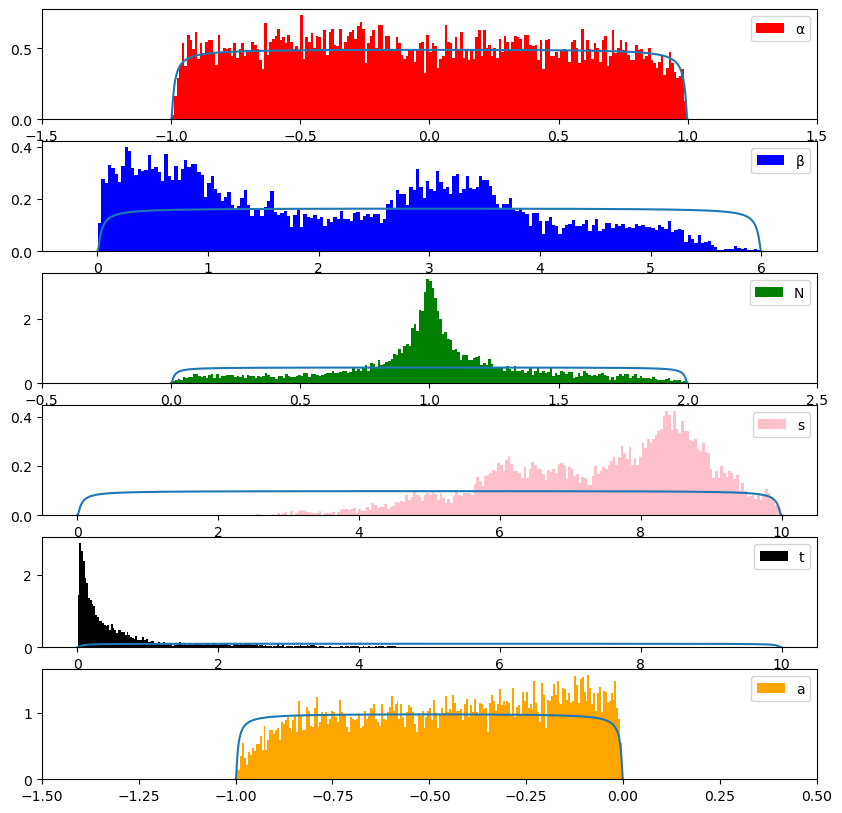

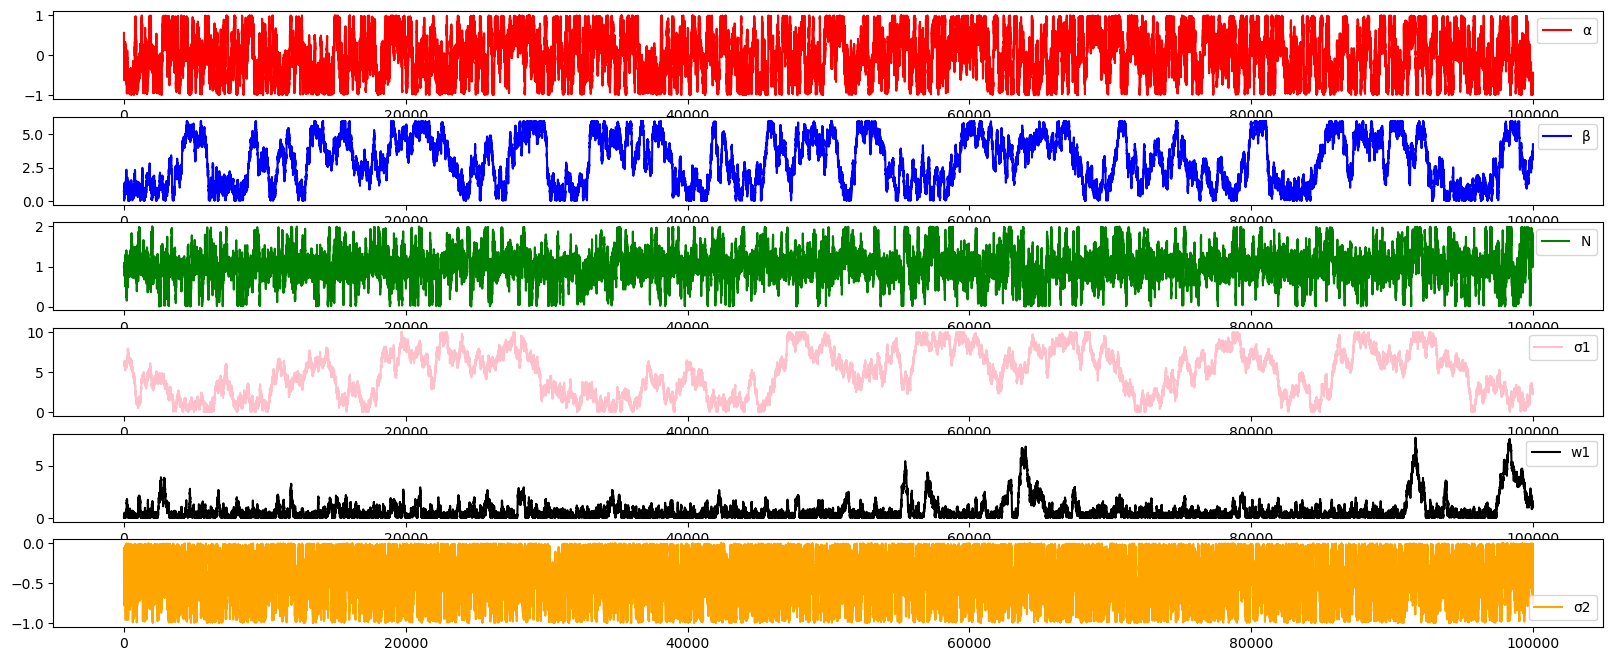

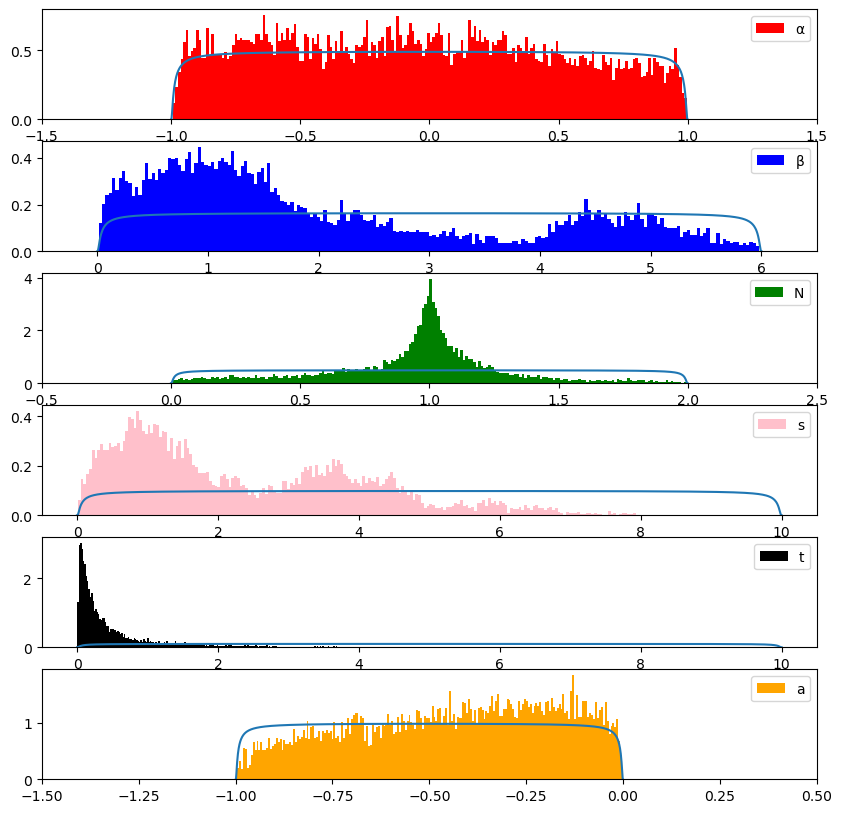

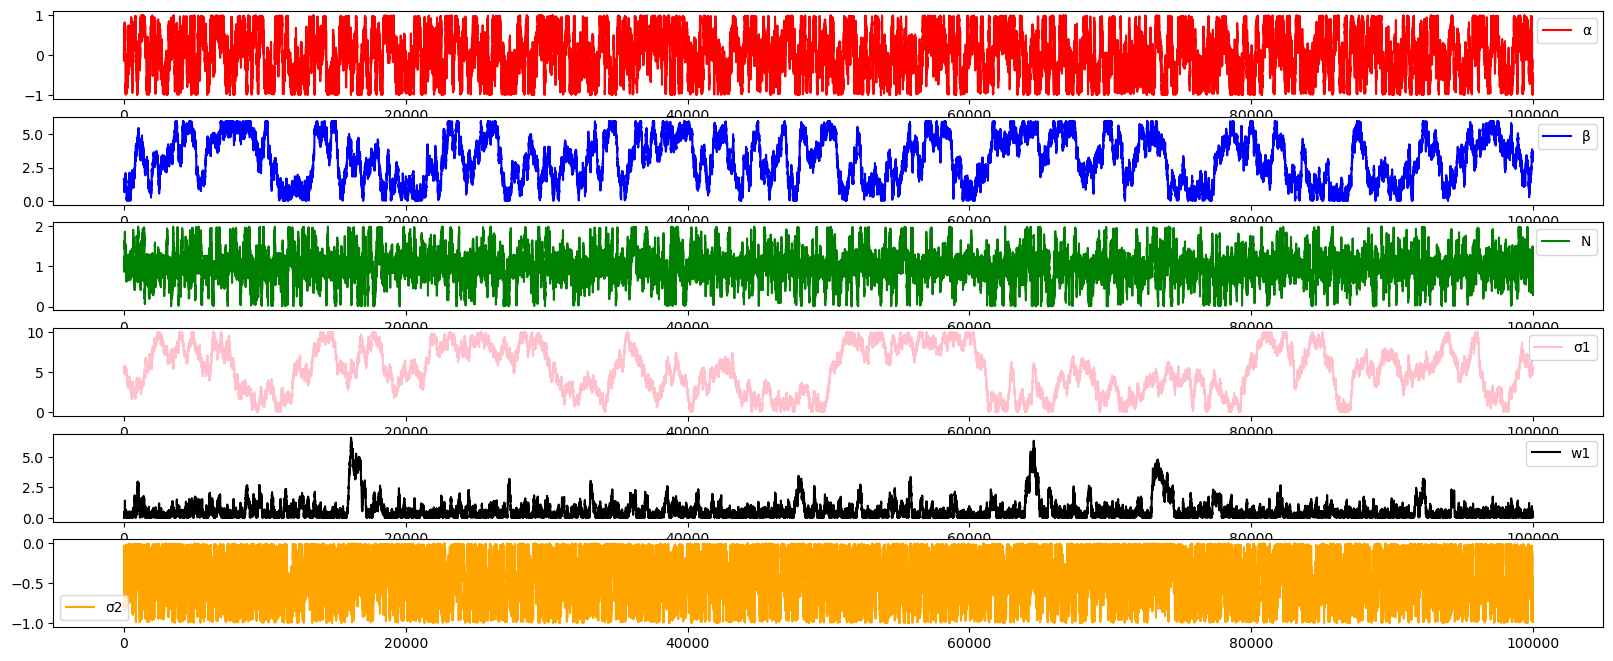

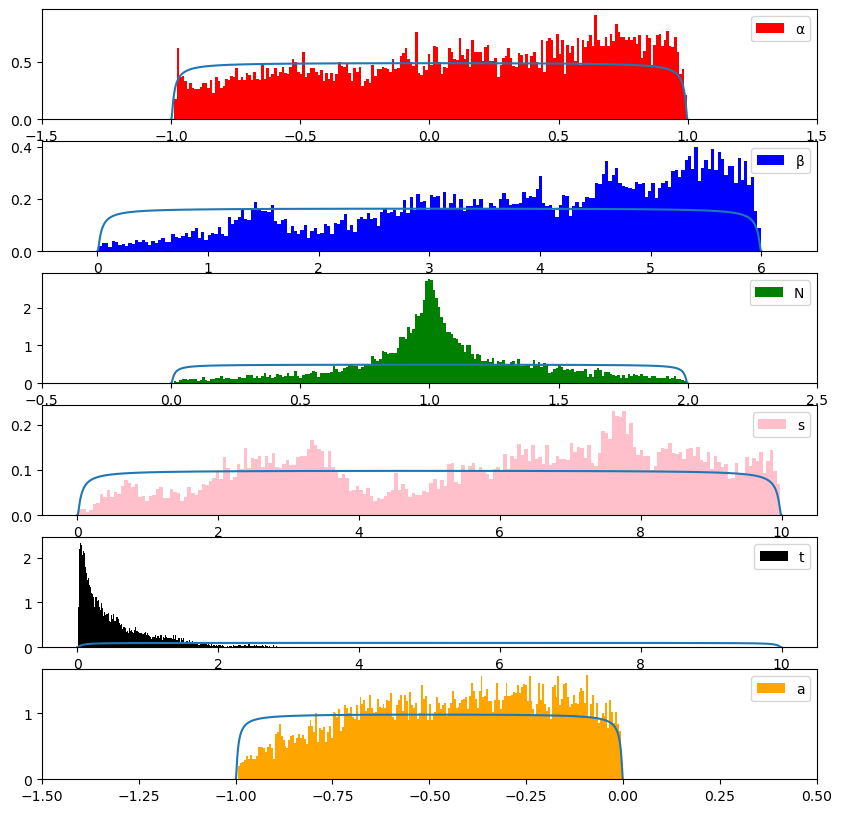

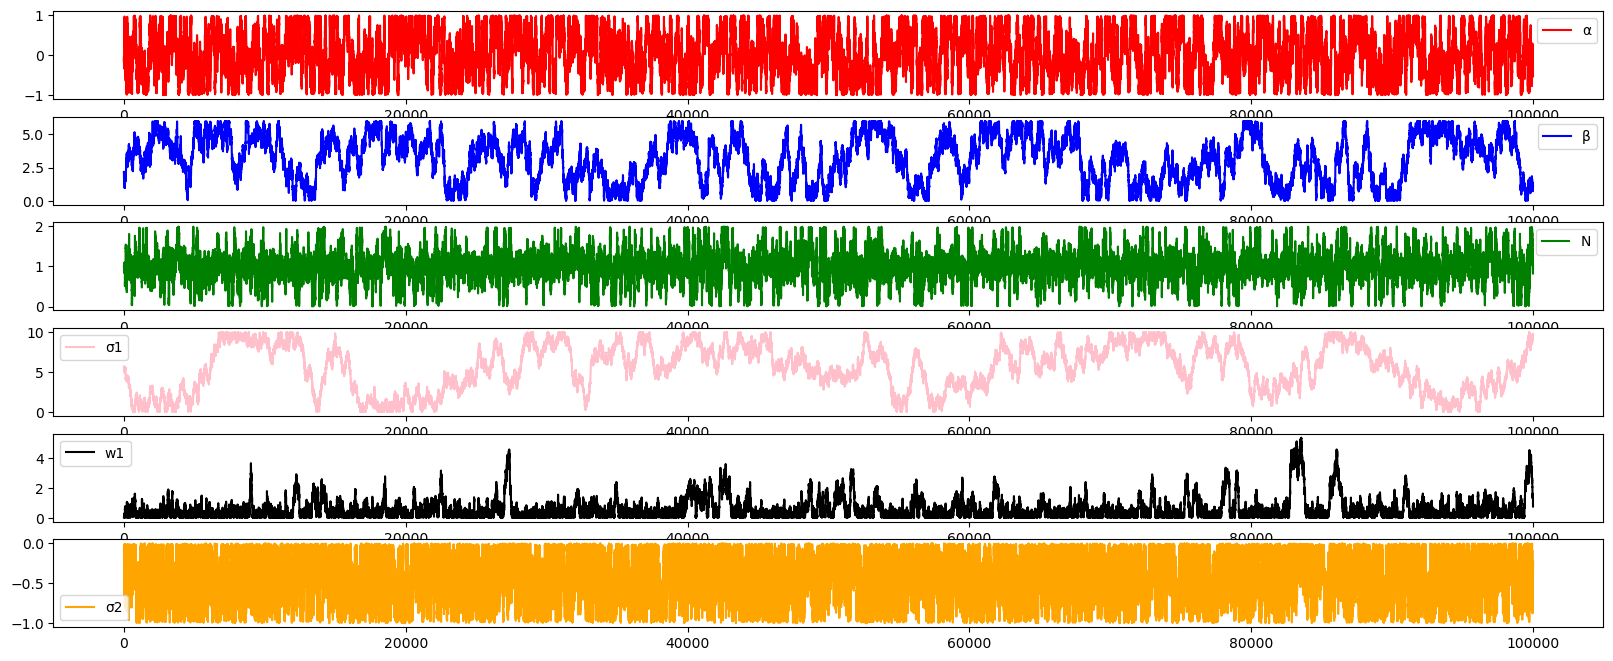

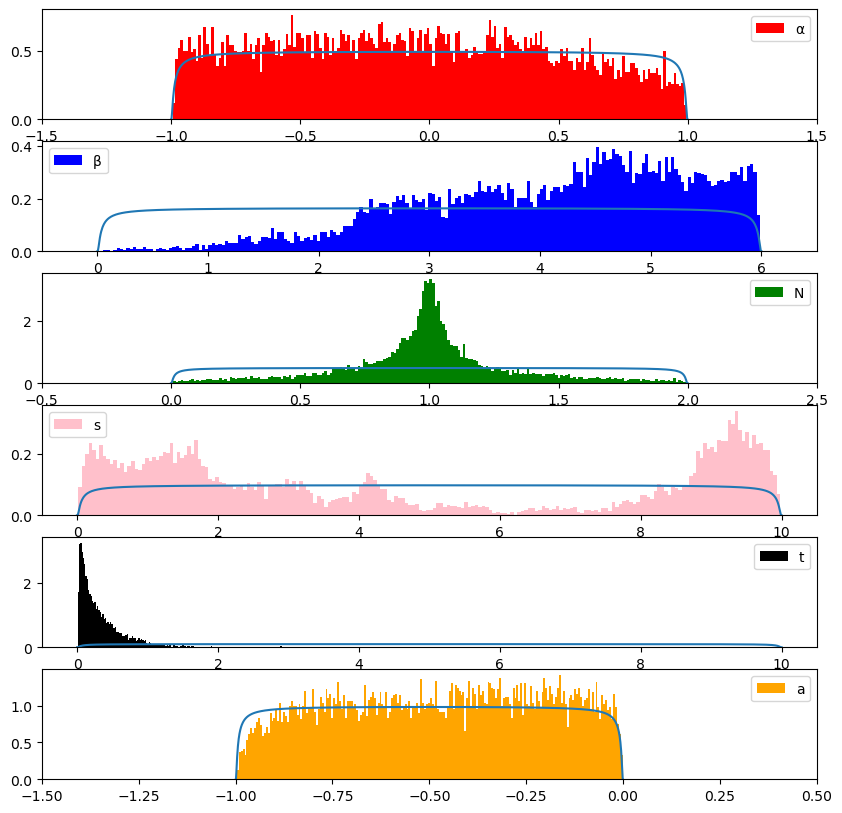

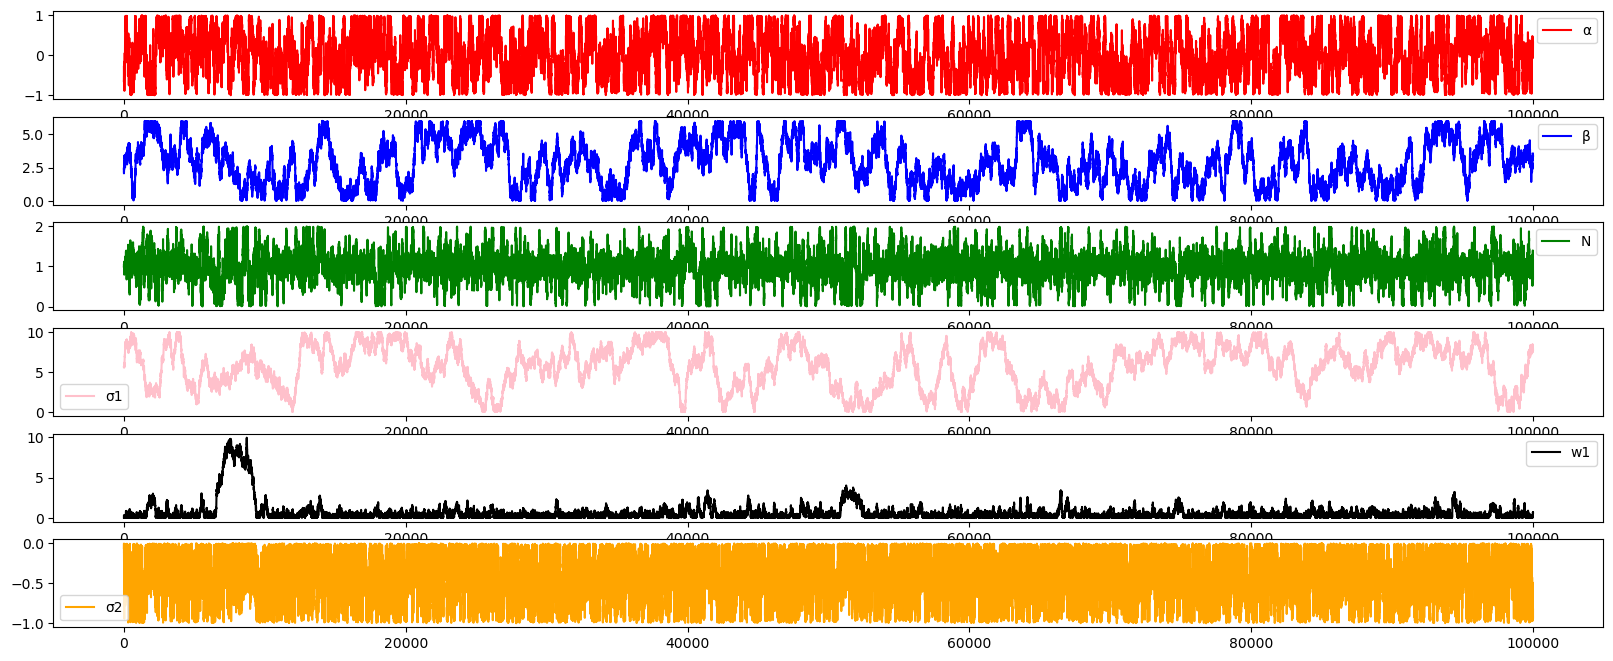

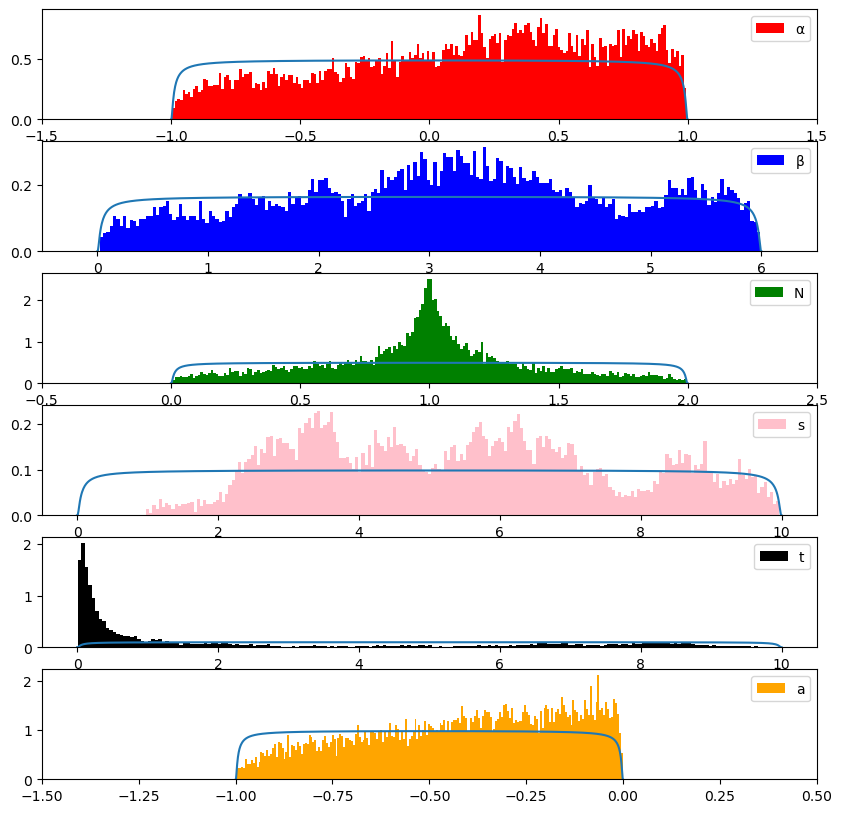

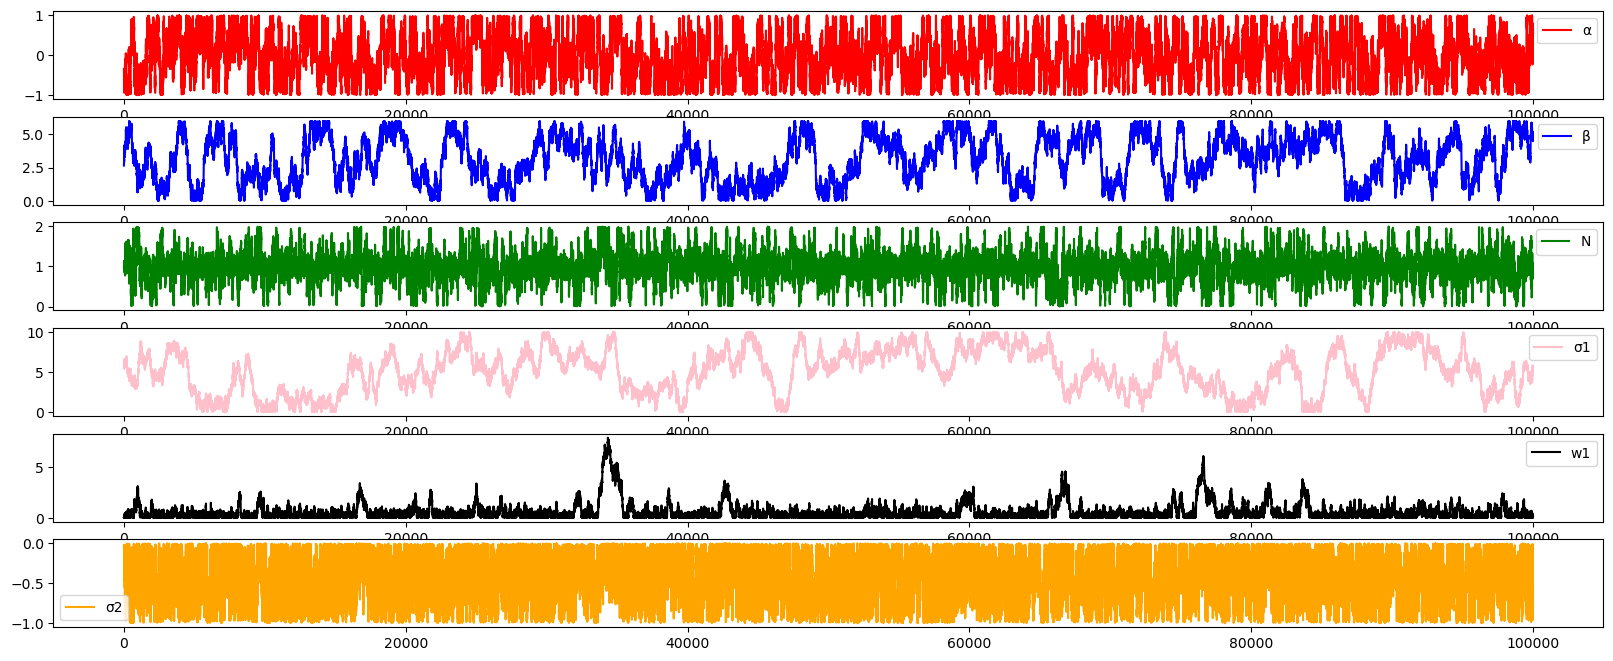

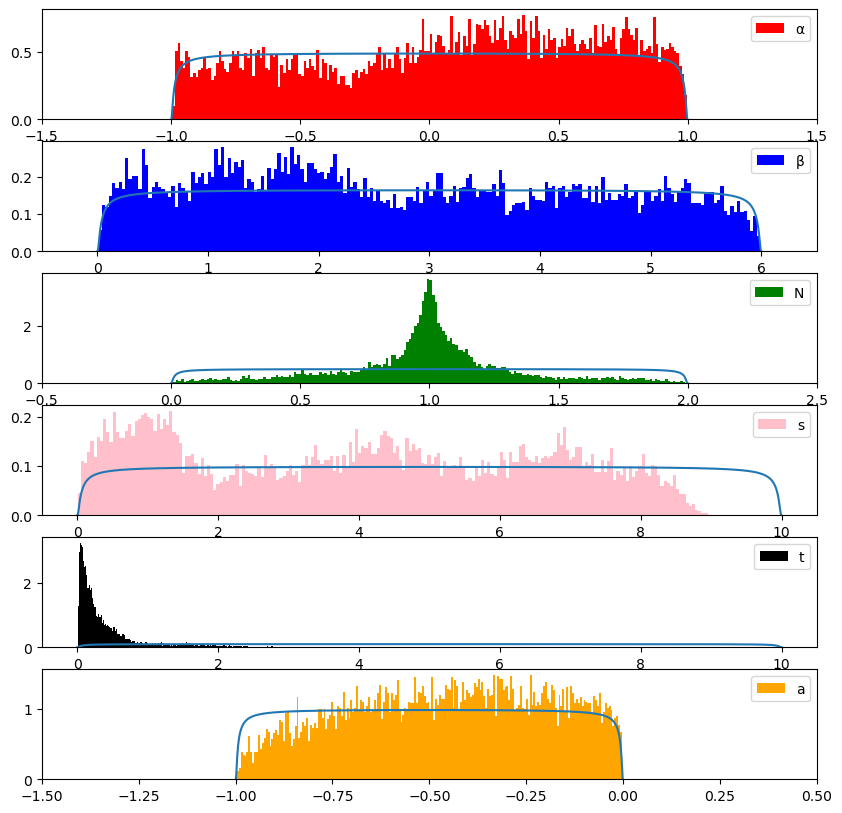

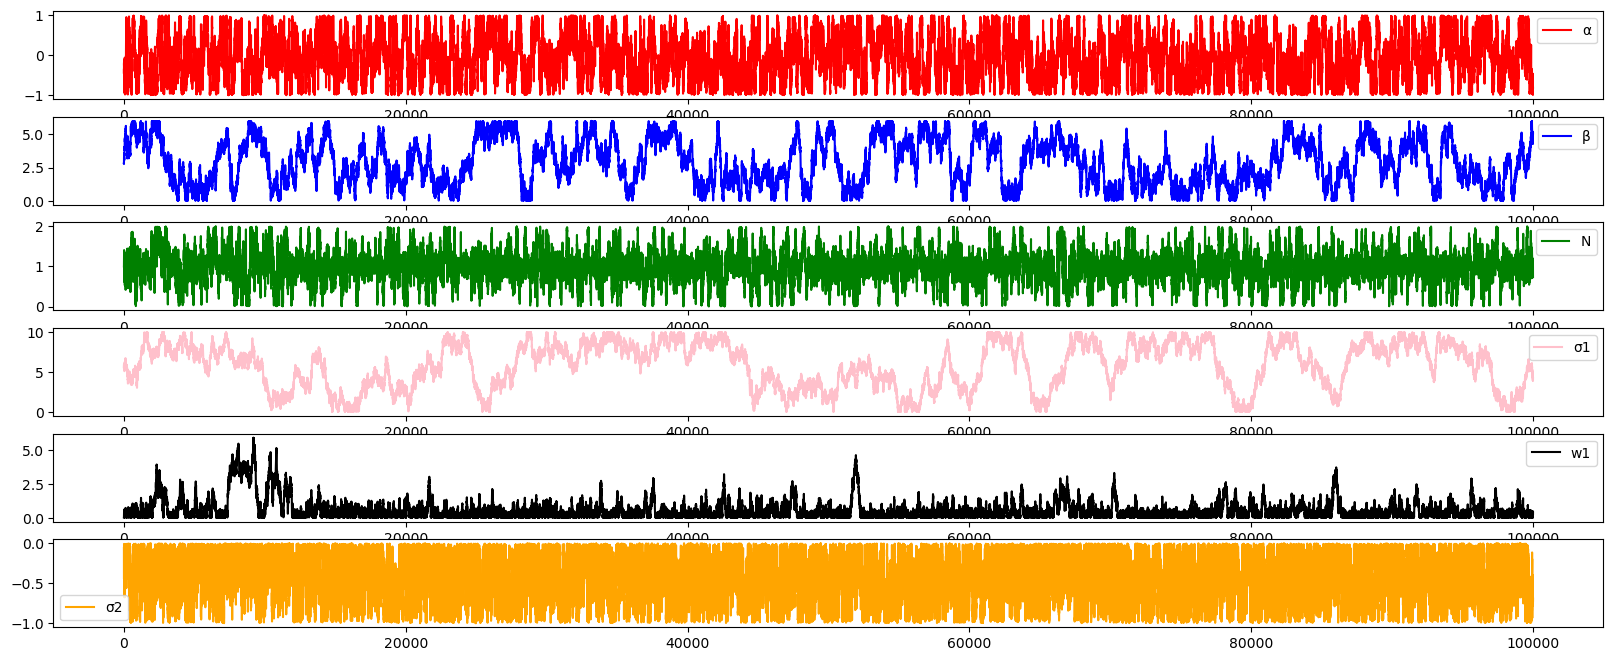

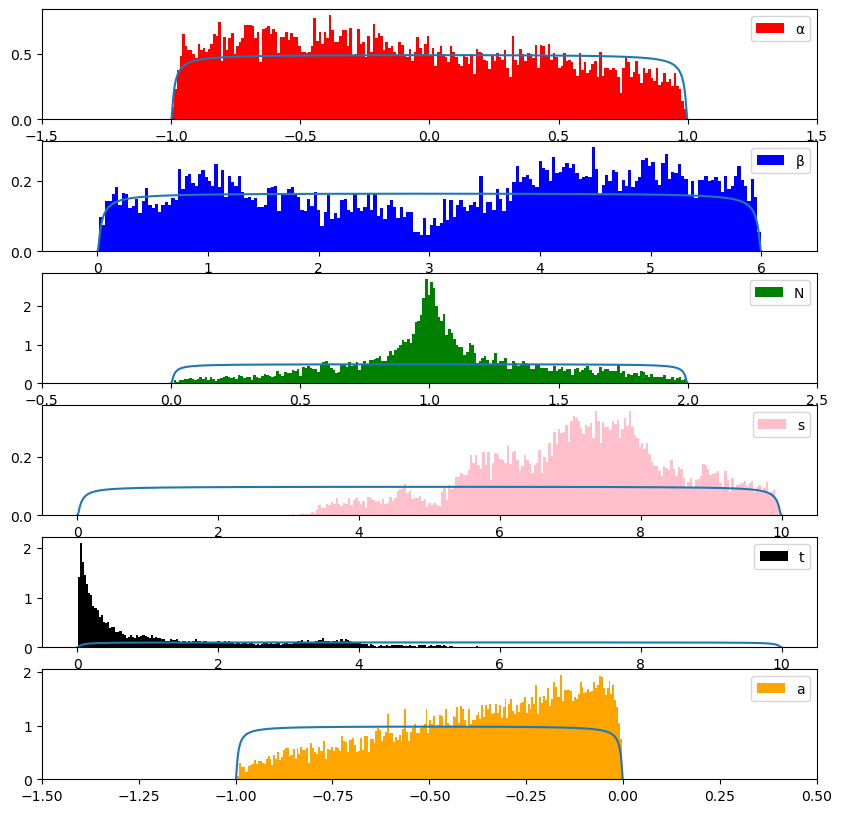

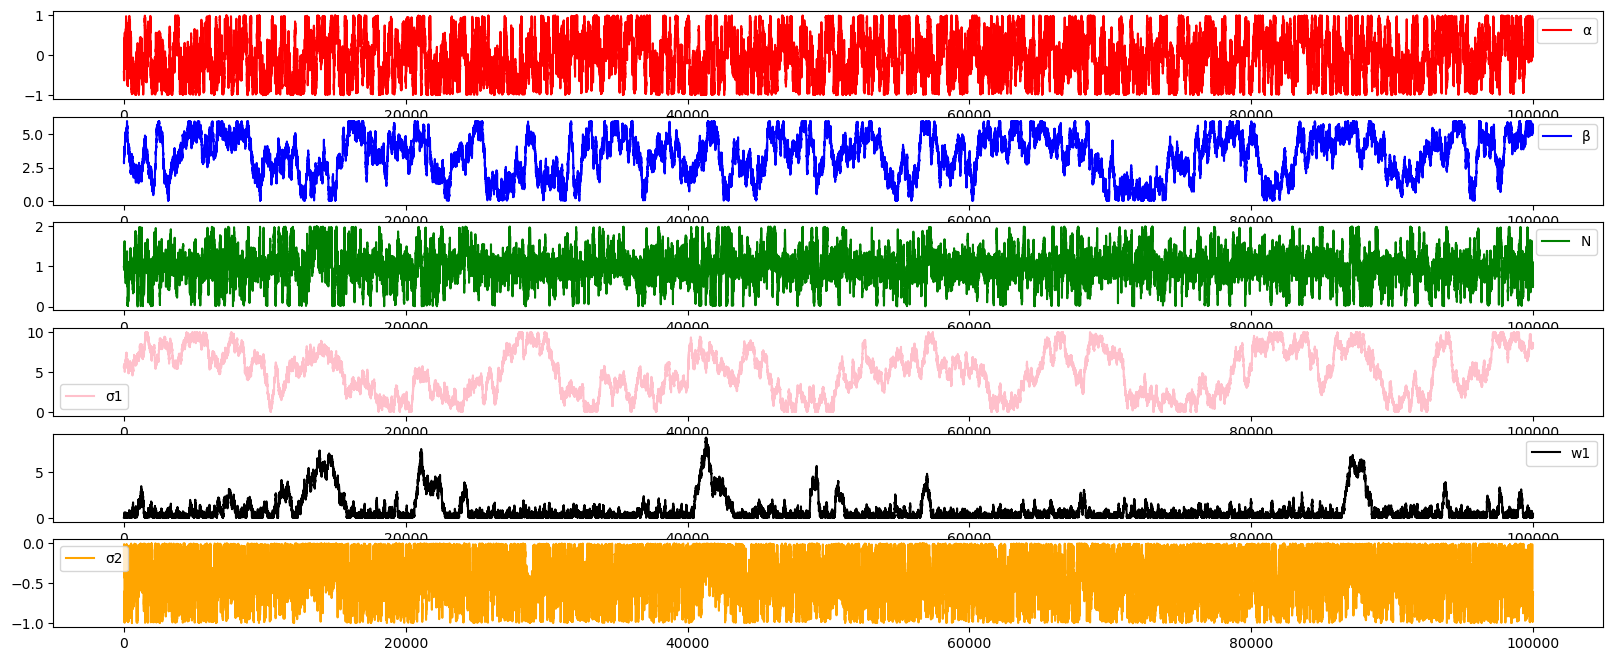

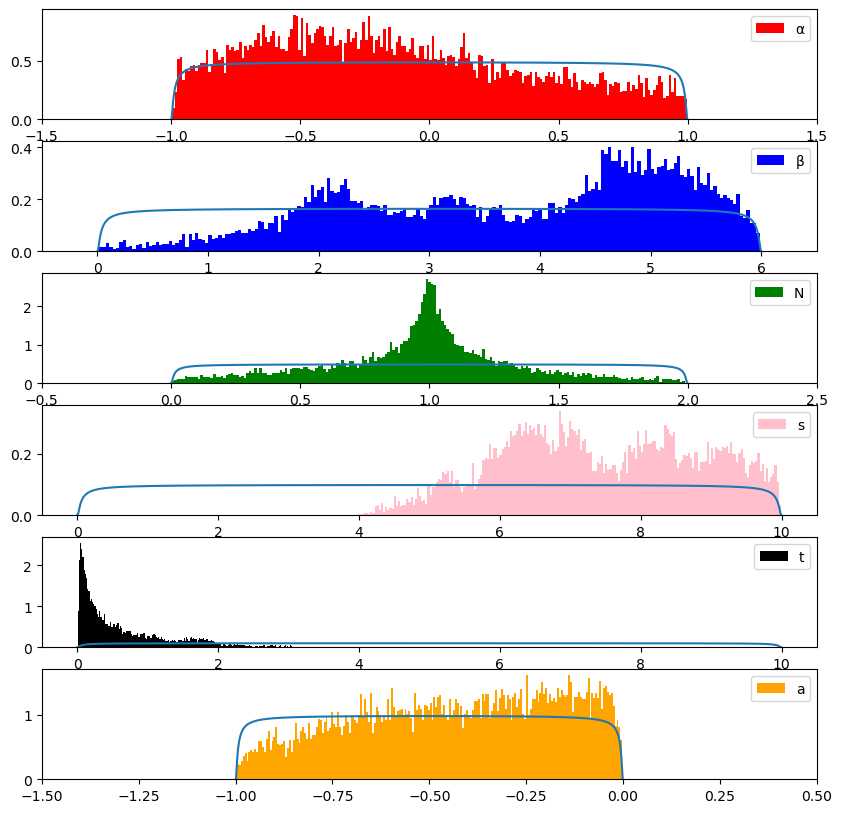

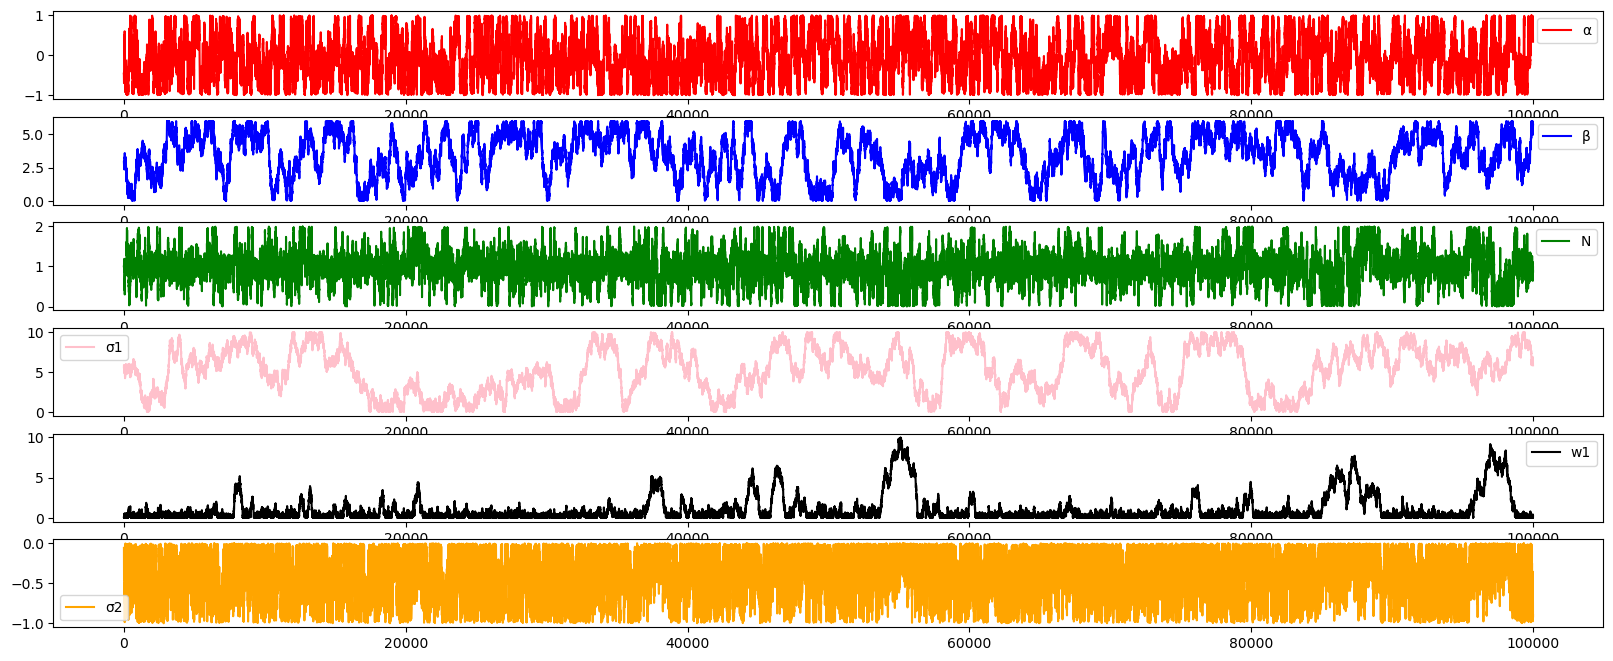

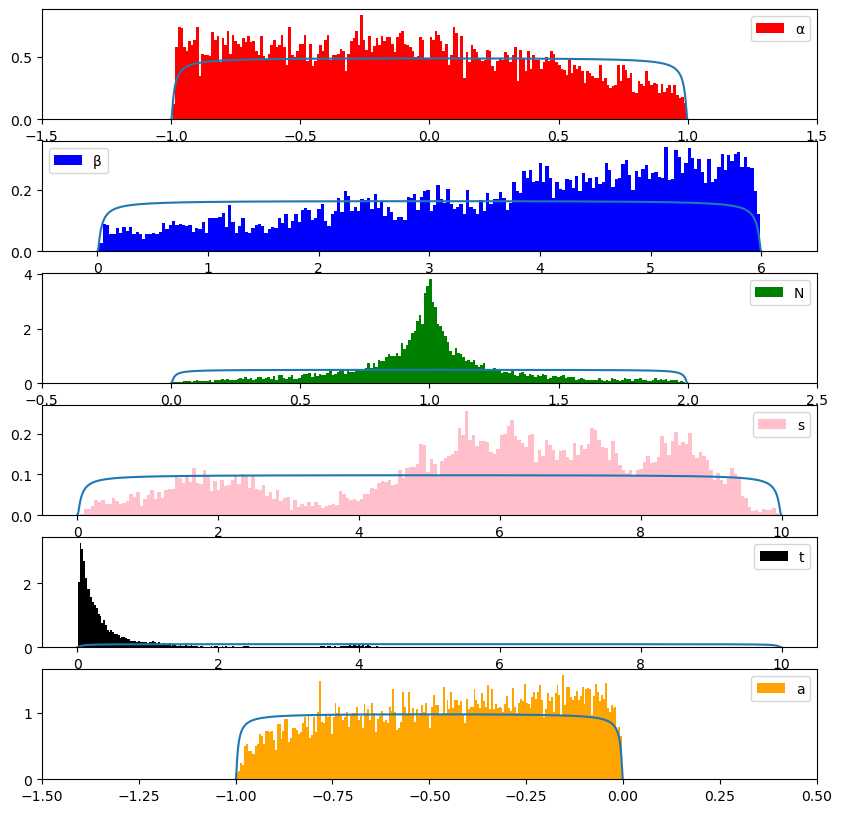

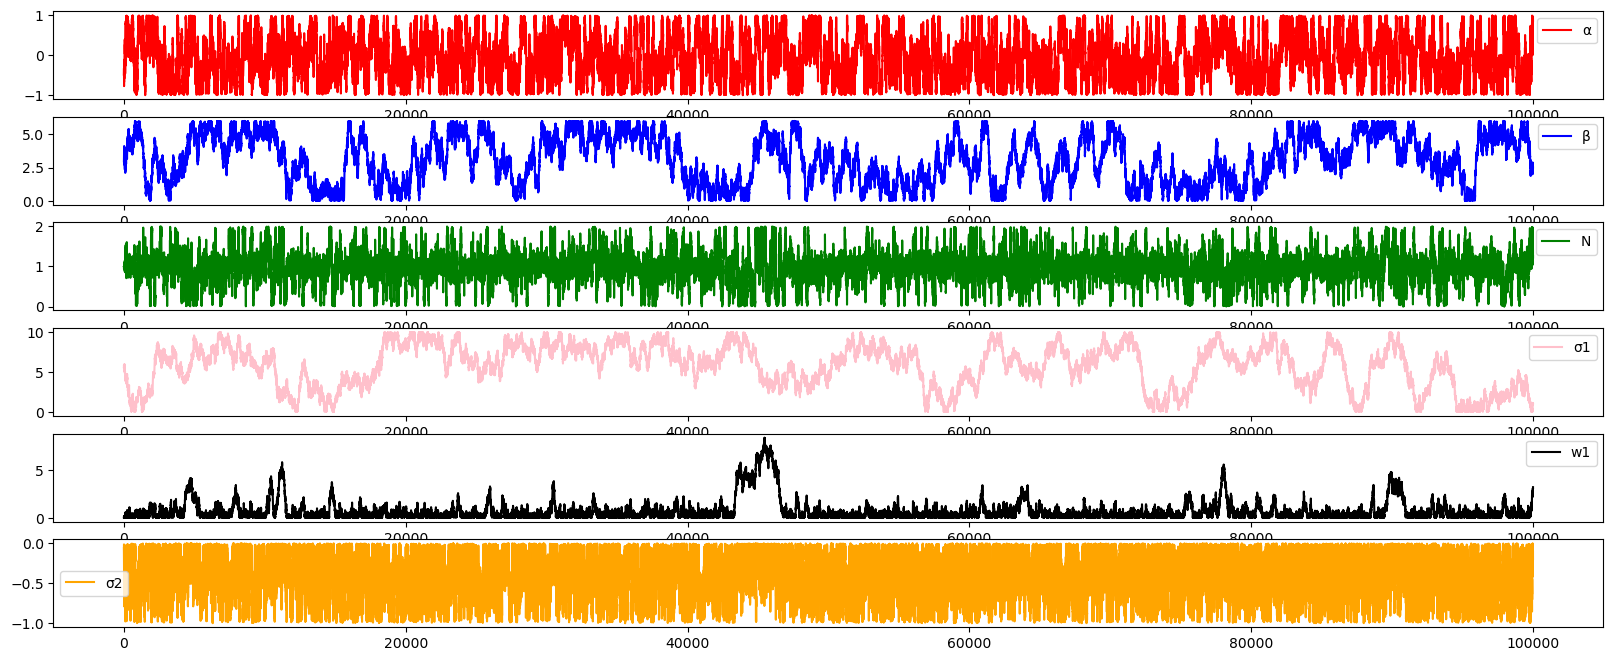

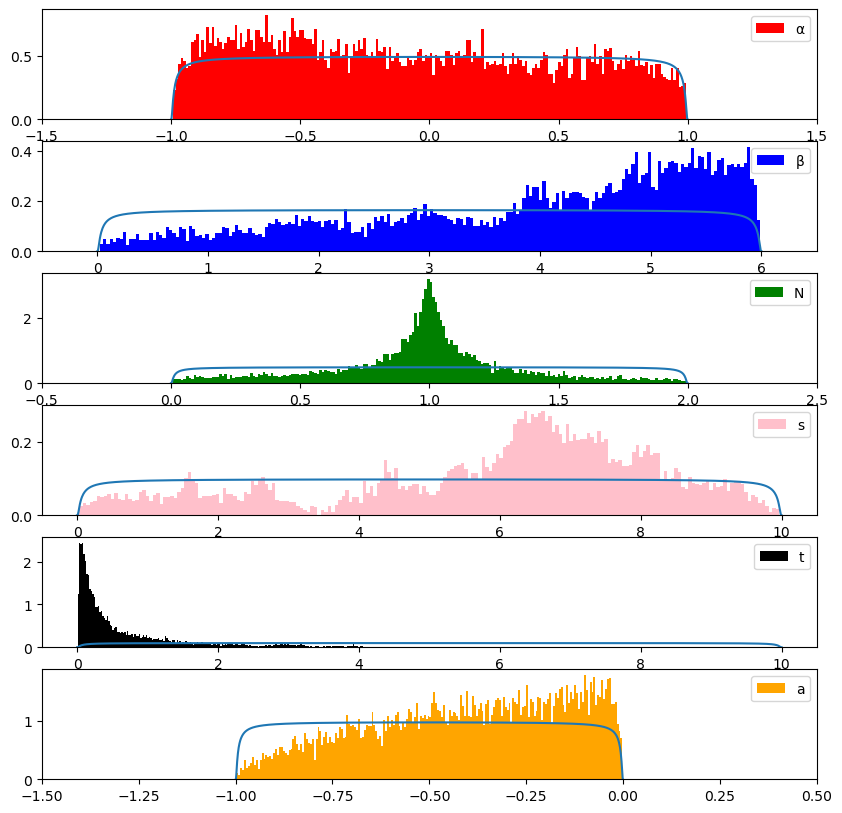

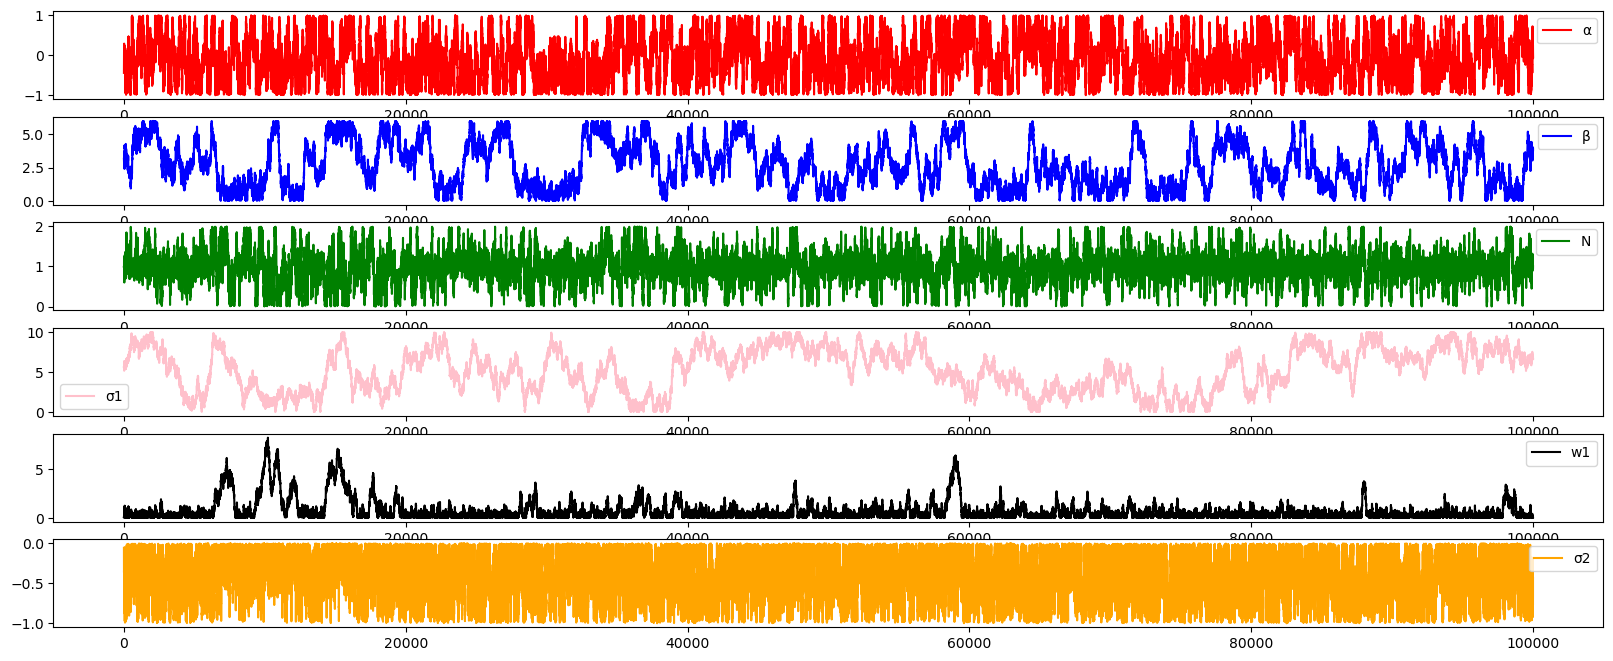

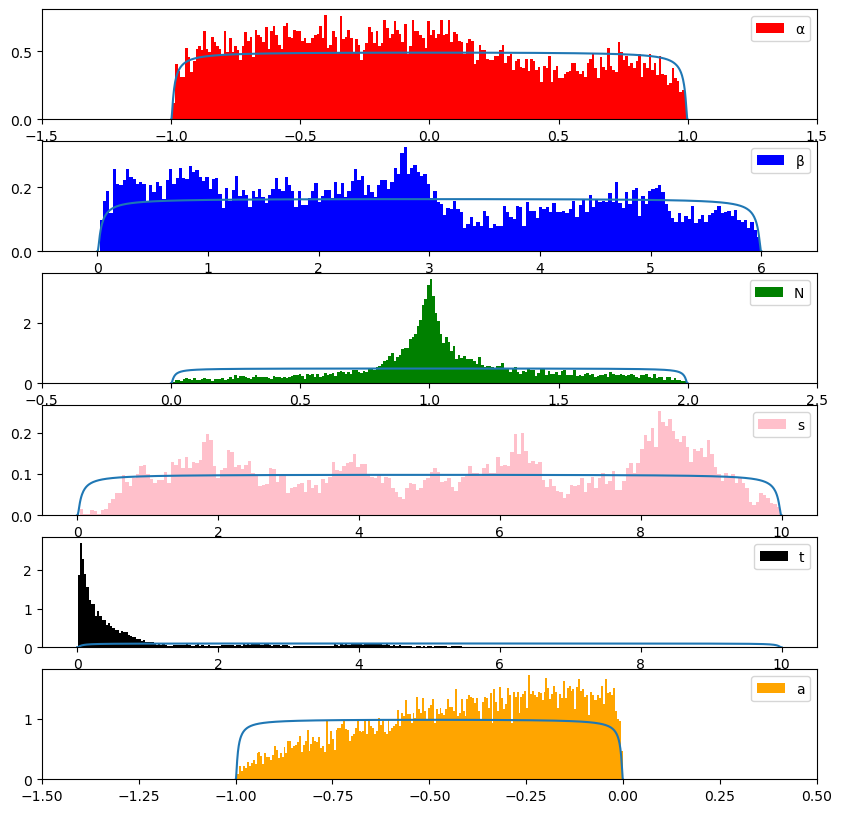

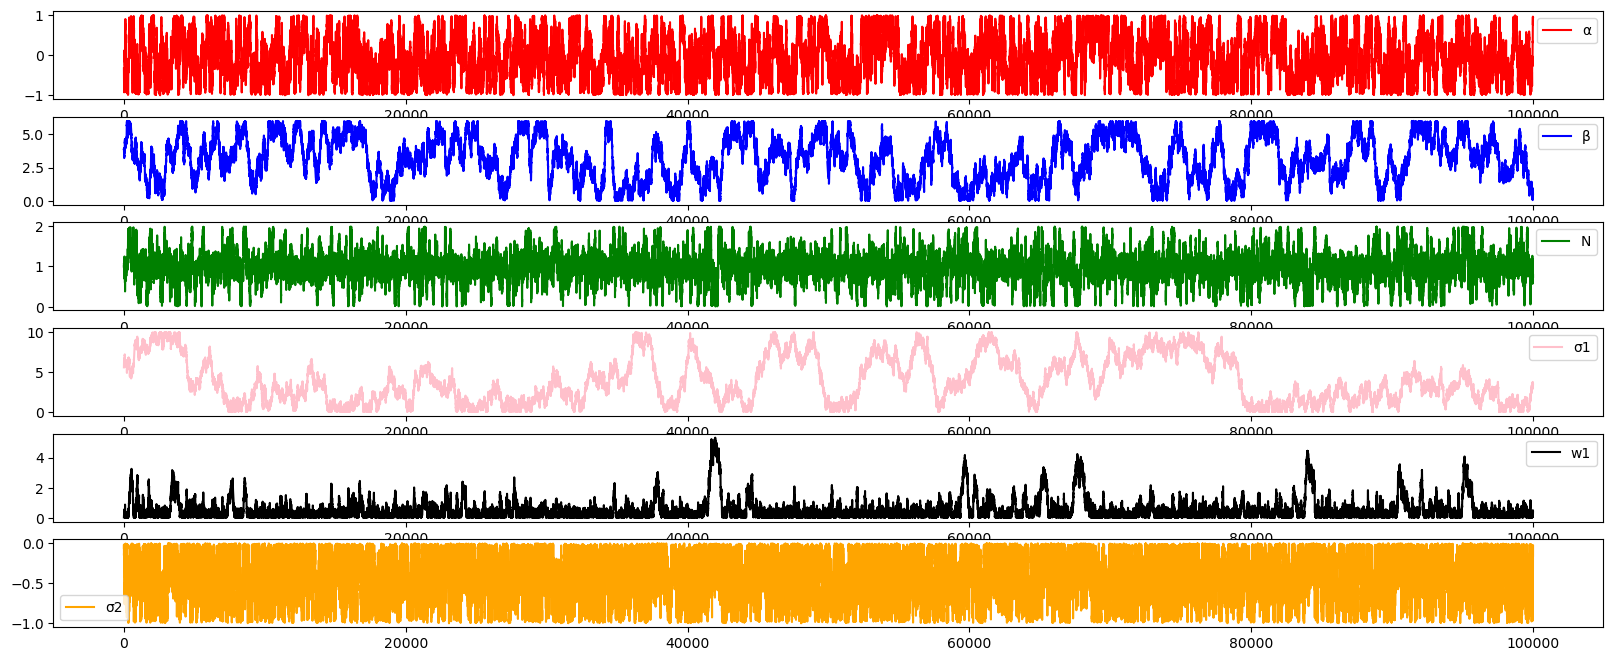

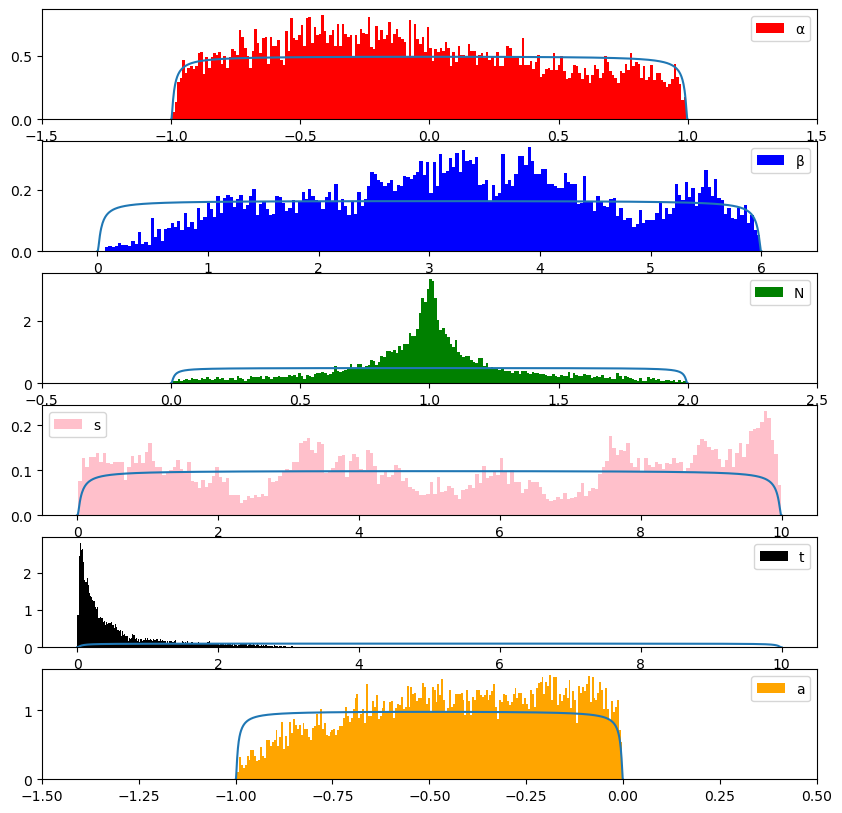

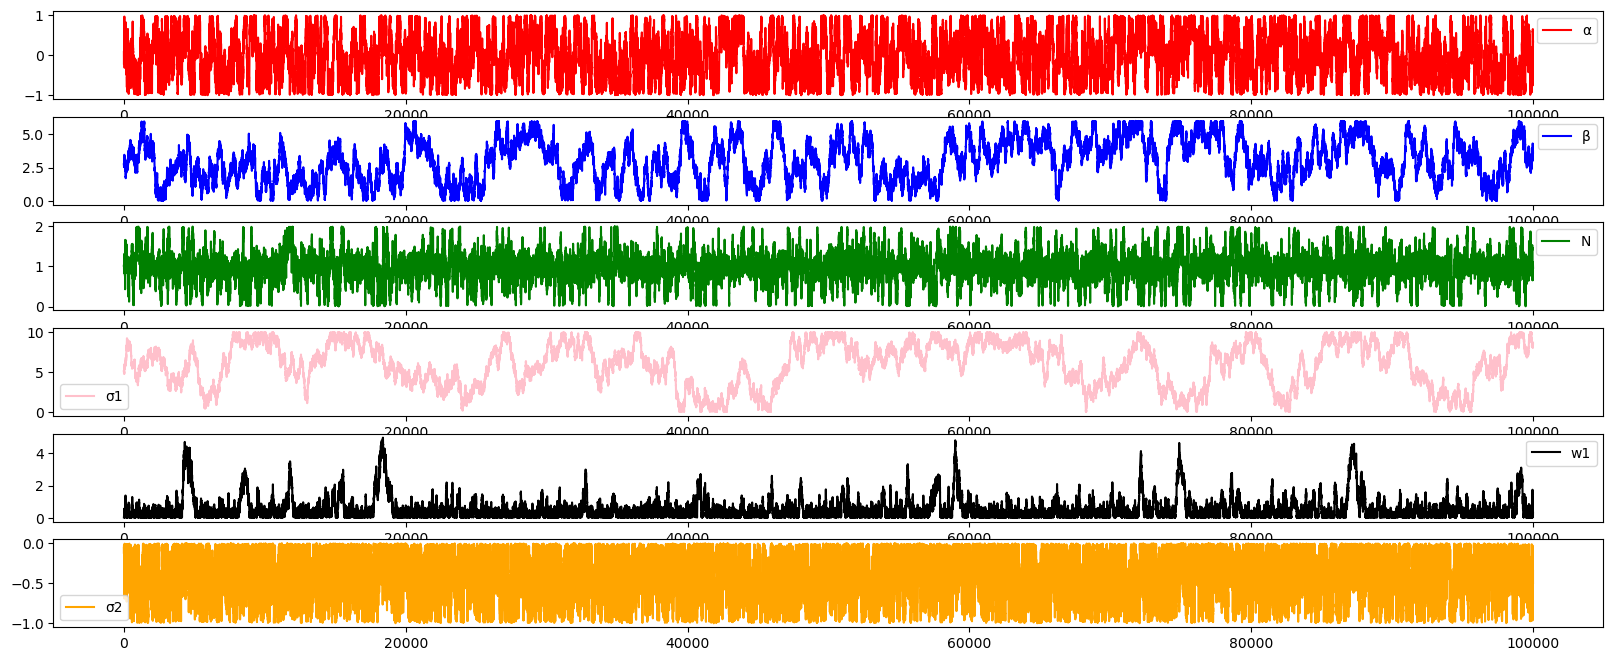

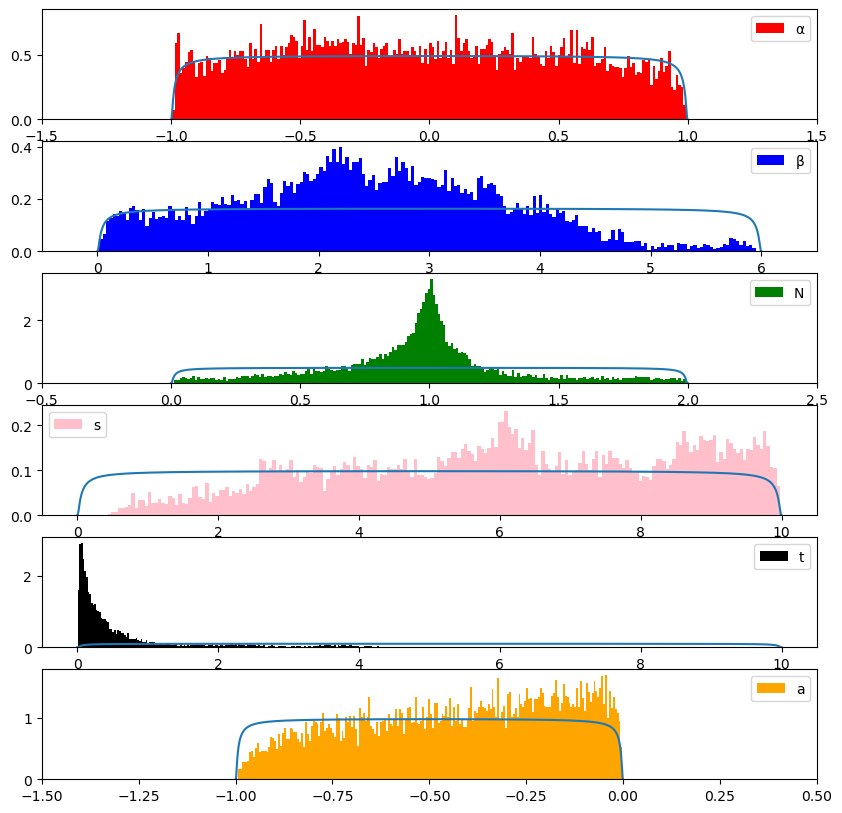

In [10]:
for i in range(0,13):
    plotrace(traces[i][0:100000].cpu(),0,kernel='combinedRBF')
    plothist(traces[i][0:100000].cpu(),fits_comb[i],200,prior=True,burn=100)

In [10]:
samplesqx=[]
samplesQv=[]
qofxs=[]
Qofvs=[]
covs=[]
covsnu=[]
for i in range(0,13):
    qofx,cov,pms,Qofv,covnu,Qvs=fits_comb[i].Uncertaintyanalysis(traces[i][::100])
    pms=tr.stack(pms)
    Qvs=tr.stack(Qvs)
    samplesqx.append(pms)
    samplesQv.append(Qvs)
    qofxs.append(qofx)
    Qofvs.append(Qofv)
    covs.append(cov)
    covsnu.append(covnu)
    print("Uncertainty Analysis",fits_comb[i].name,"done")

Uncertainty Analysis z=1a done
Uncertainty Analysis z=2a done
Uncertainty Analysis z=3a done
Uncertainty Analysis z=4a done
Uncertainty Analysis z=5a done
Uncertainty Analysis z=6a done
Uncertainty Analysis z=7a done
Uncertainty Analysis z=8a done
Uncertainty Analysis z=9a done
Uncertainty Analysis z=10a done
Uncertainty Analysis z=11a done
Uncertainty Analysis z=12a done
Uncertainty Analysis z=mock done


In [11]:
nn = np.linspace(0,20,128)
iB = np.zeros((nn.shape[0],Nx))
fe=FE2_Integrator(x_grid)
for k in range(nn.shape[0]):
    iB[k,:] = fe.set_up_integration(Kernel= lambda x : np.cos(nn[k]*x))
Qnu=[]
for i in range(0,13):
    ttQ = samplesqx[i]@iB.T
    Qnu.append(ttQ)
    print("ITD",fits_comb[i].name,"done")

ITD z=1a done
ITD z=2a done
ITD z=3a done
ITD z=4a done
ITD z=5a done
ITD z=6a done
ITD z=7a done
ITD z=8a done
ITD z=9a done
ITD z=10a done
ITD z=11a done
ITD z=12a done
ITD z=mock done


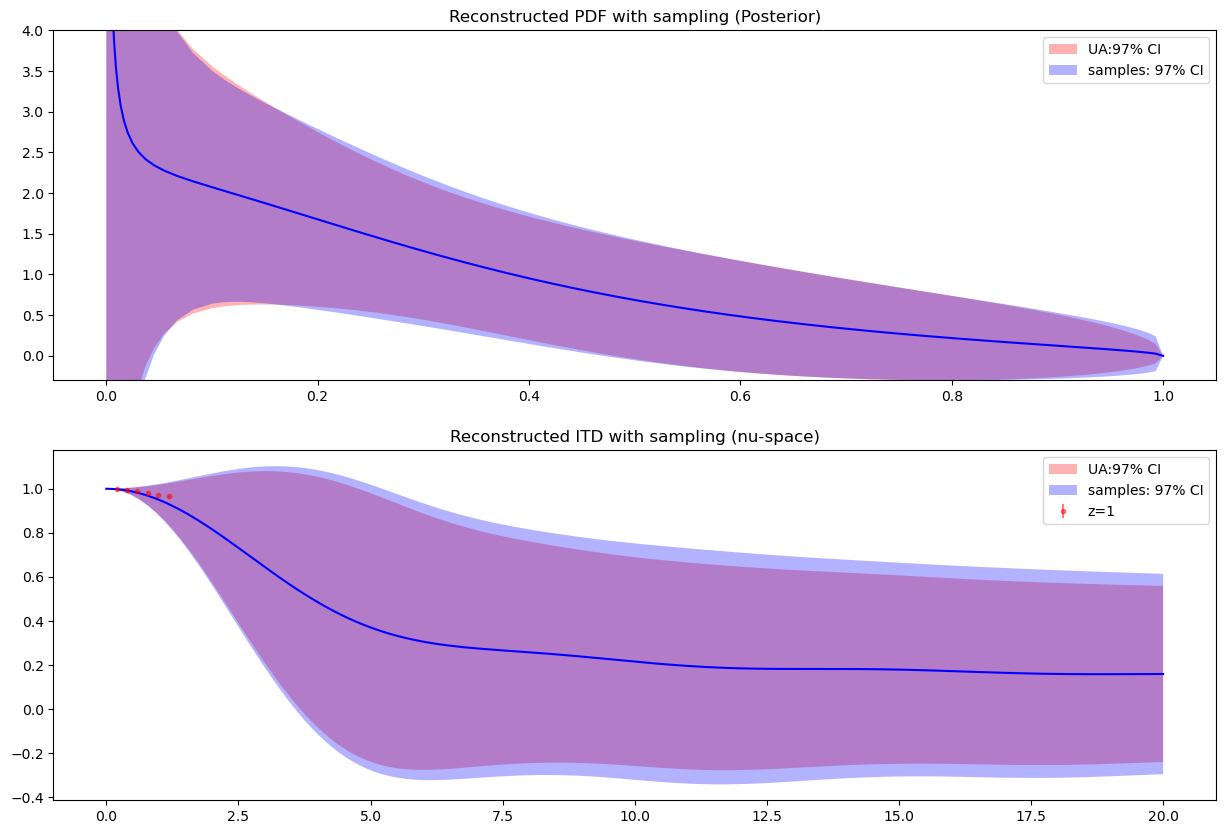

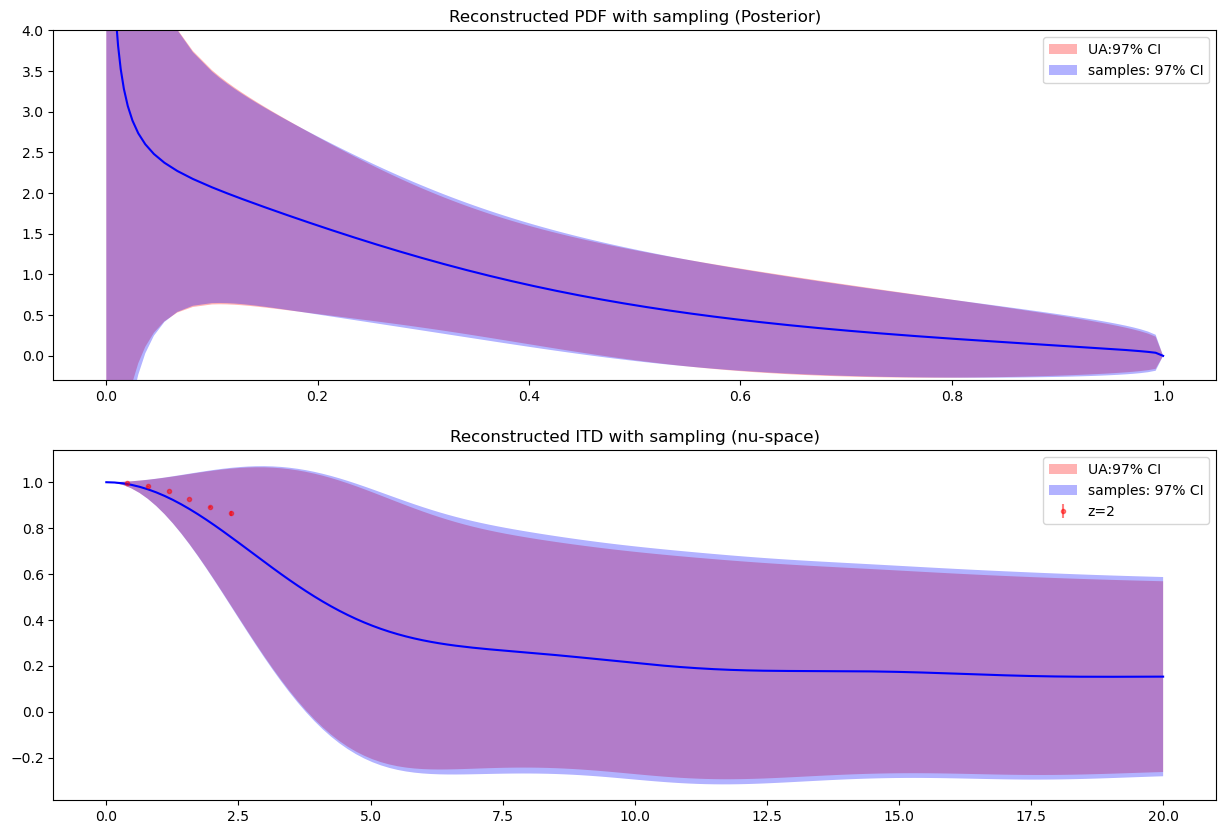

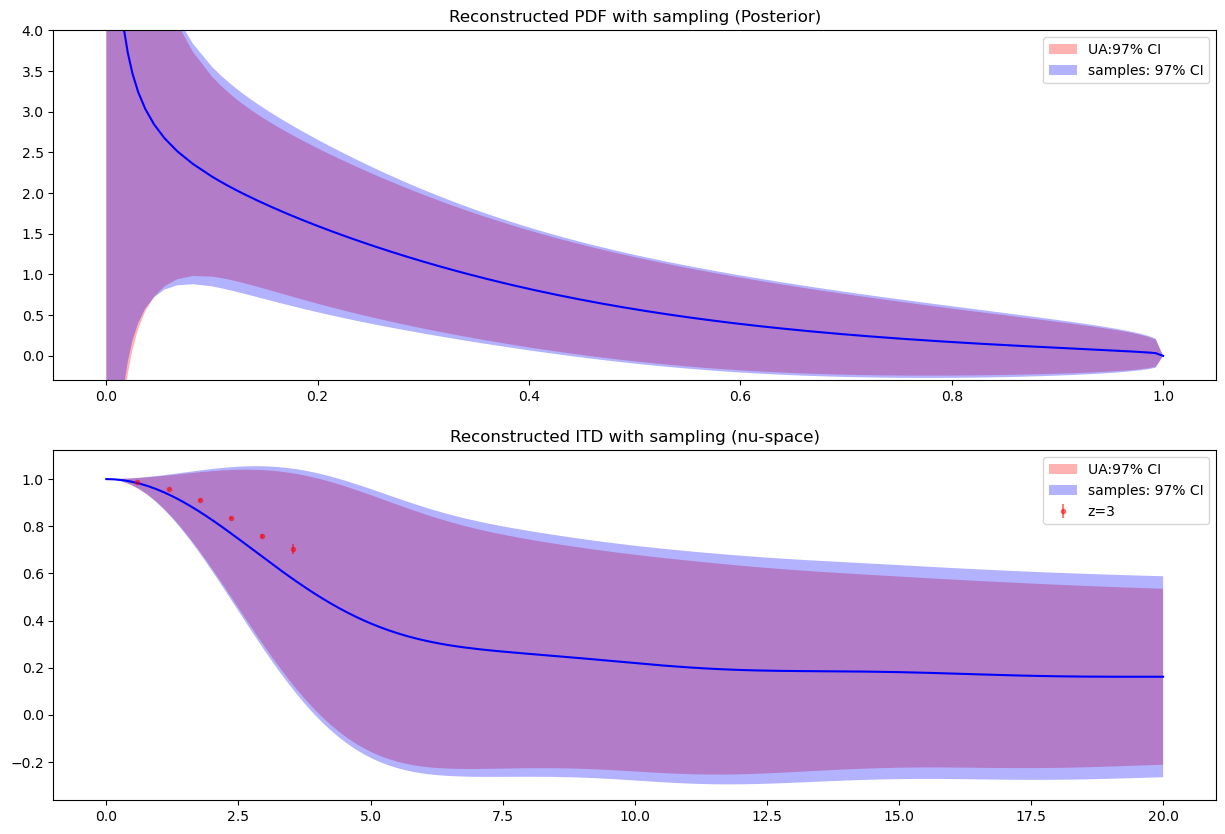

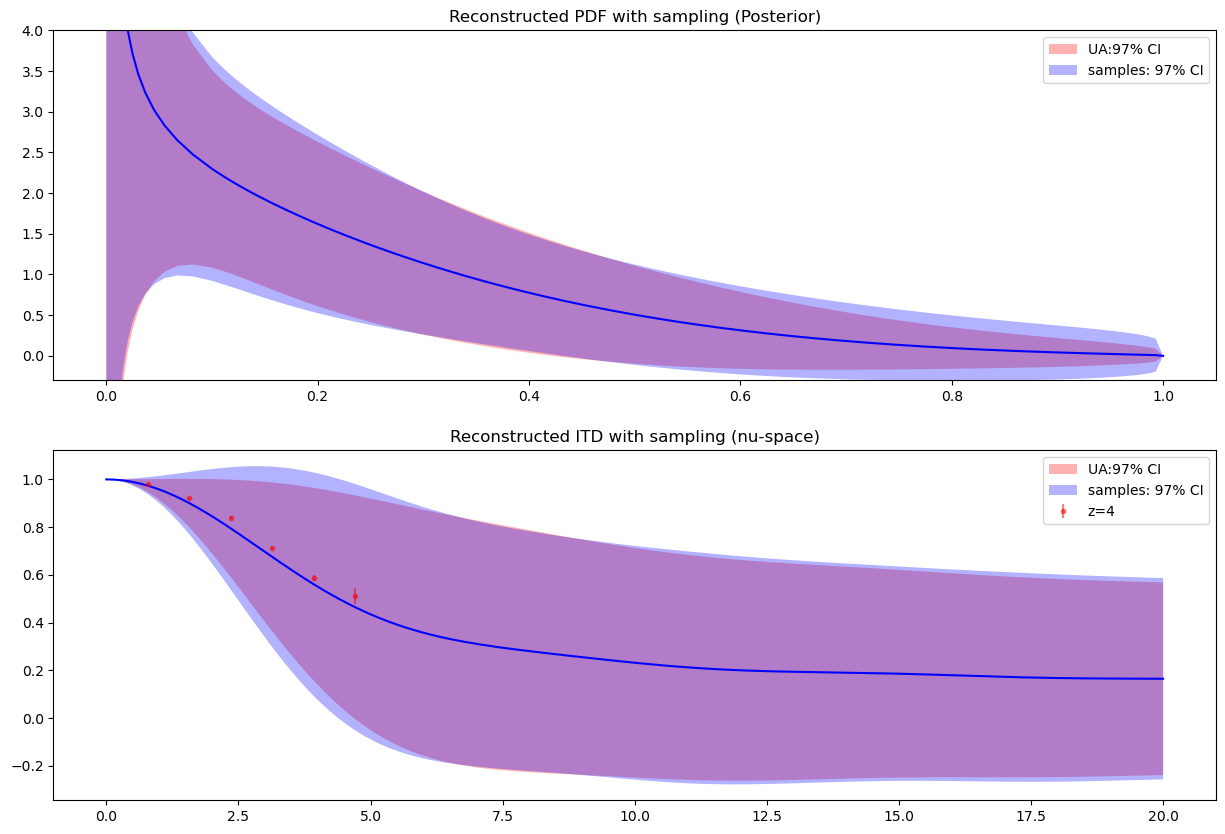

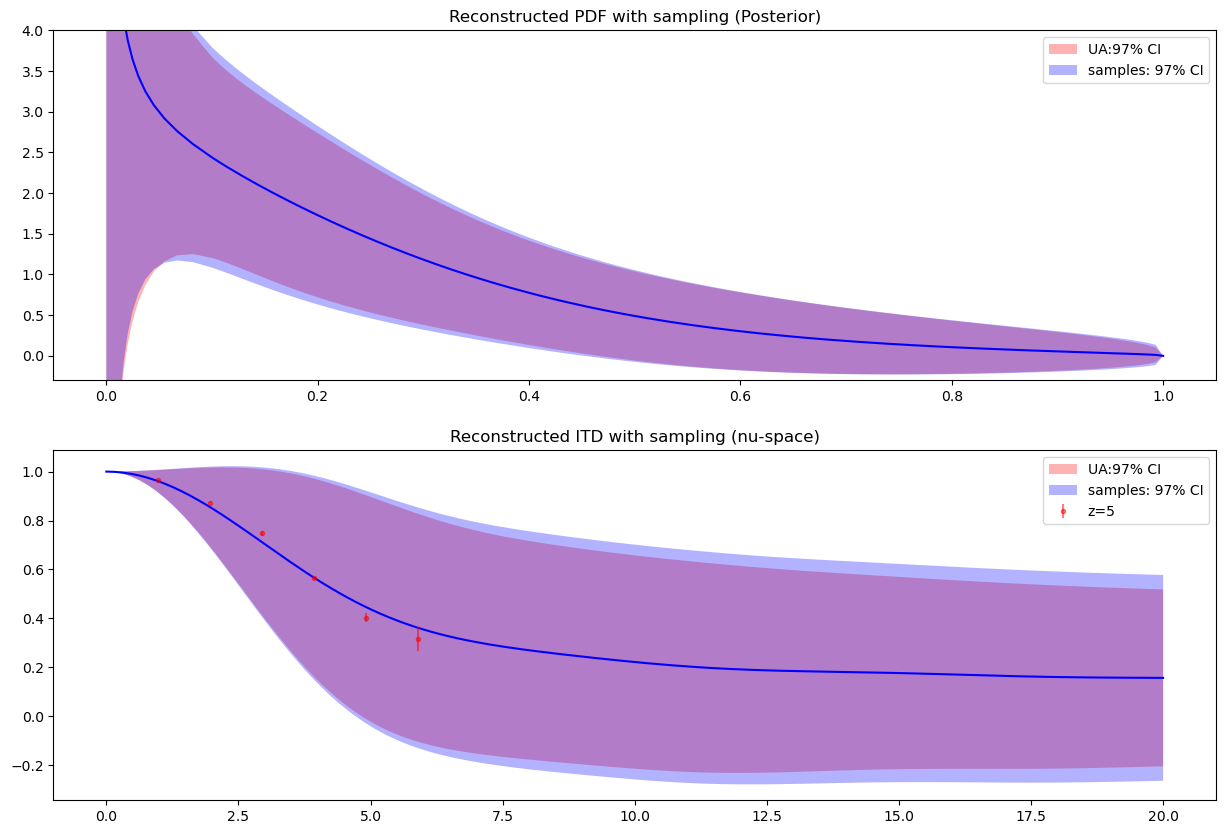

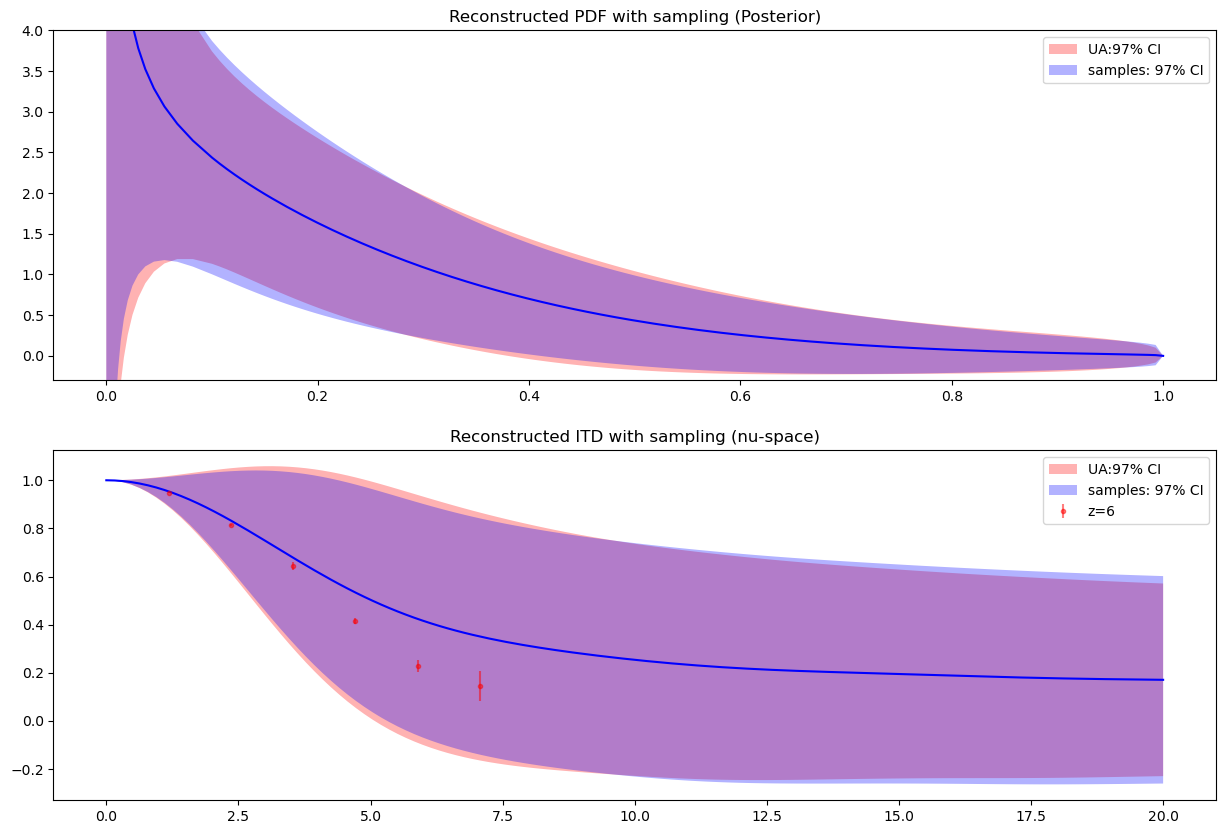

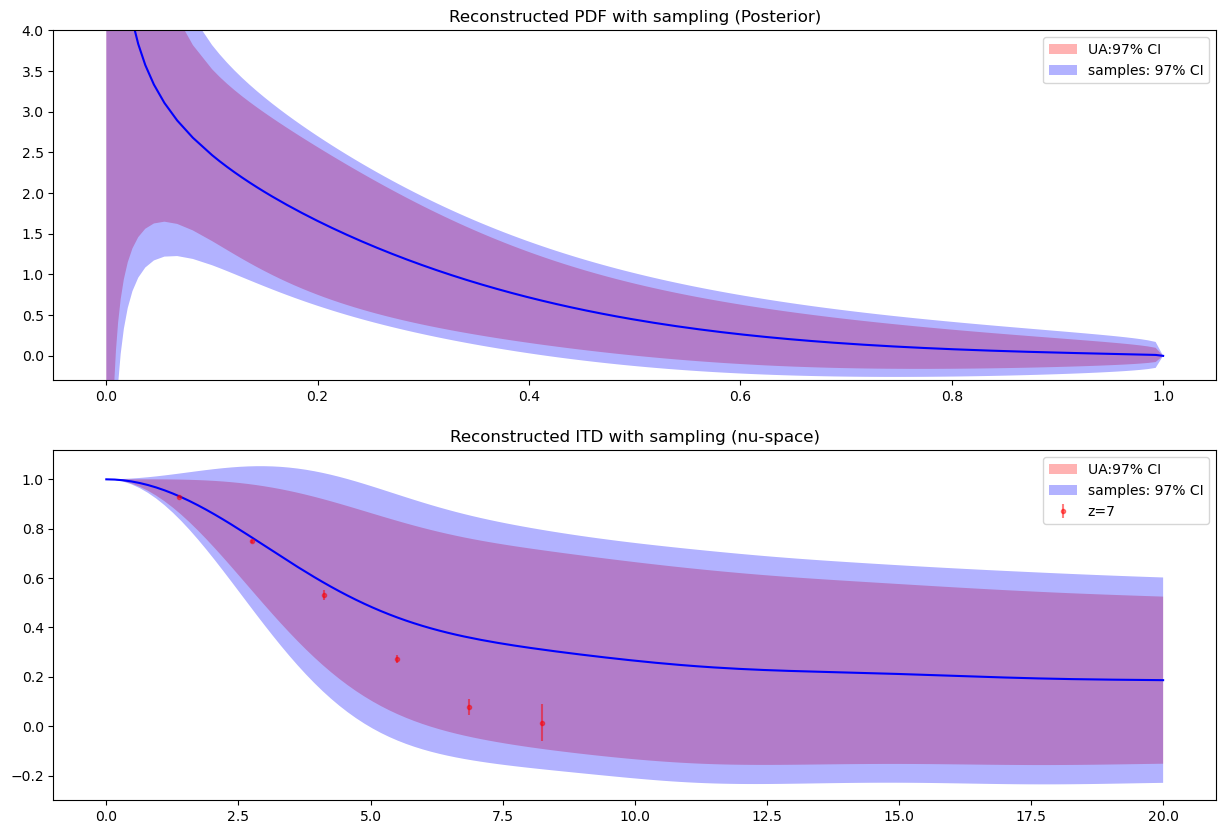

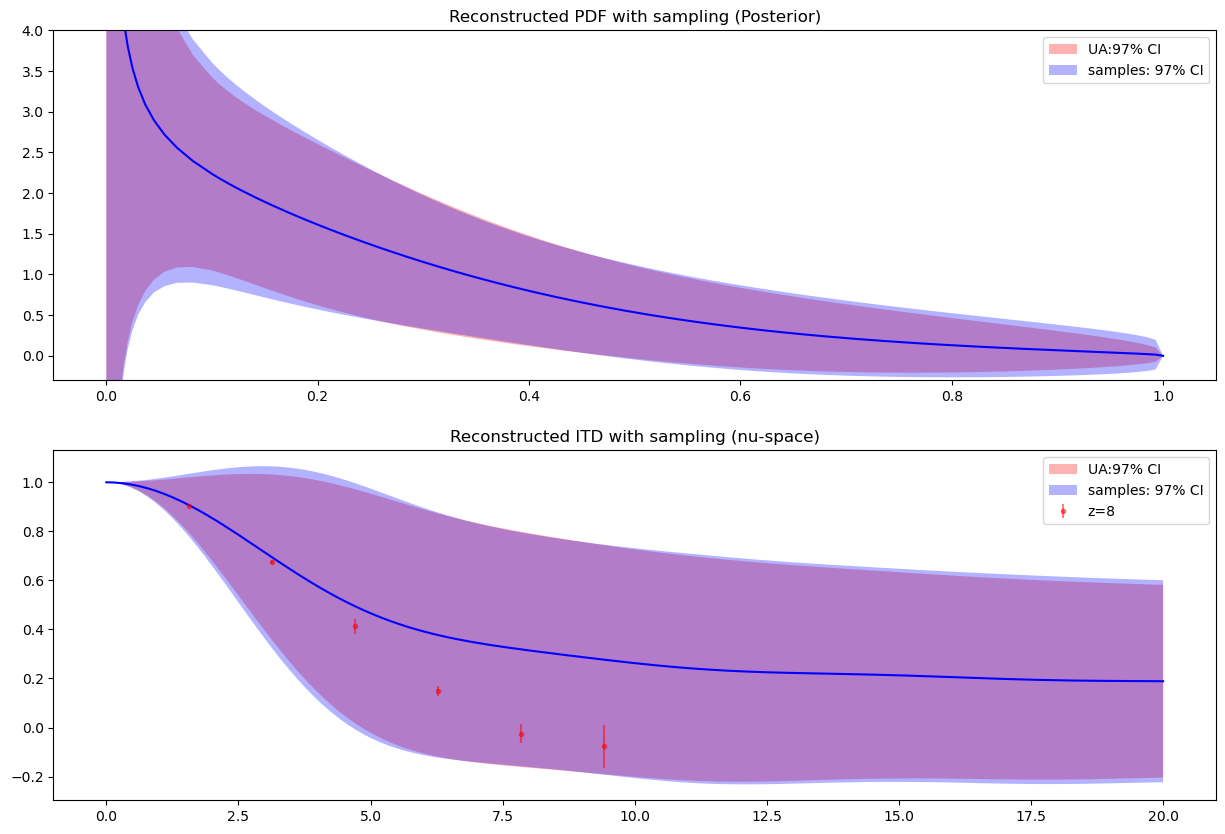

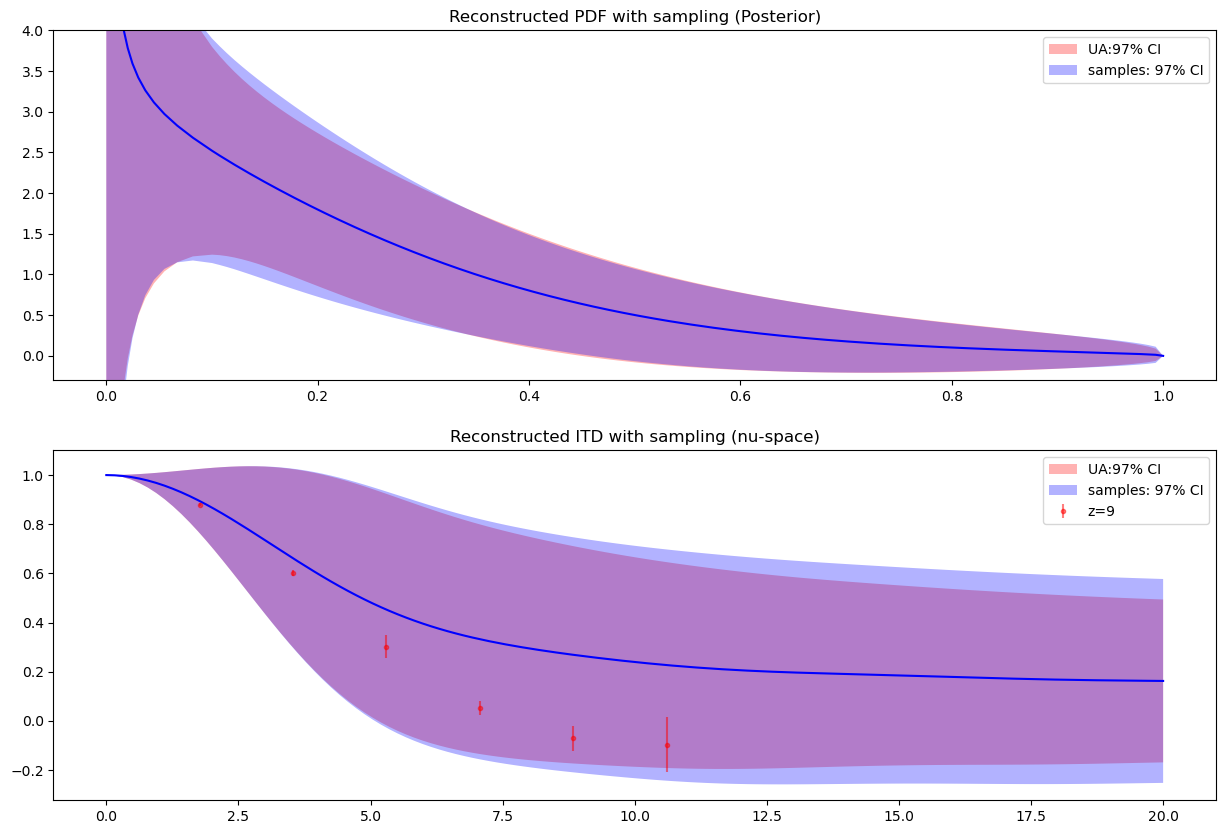

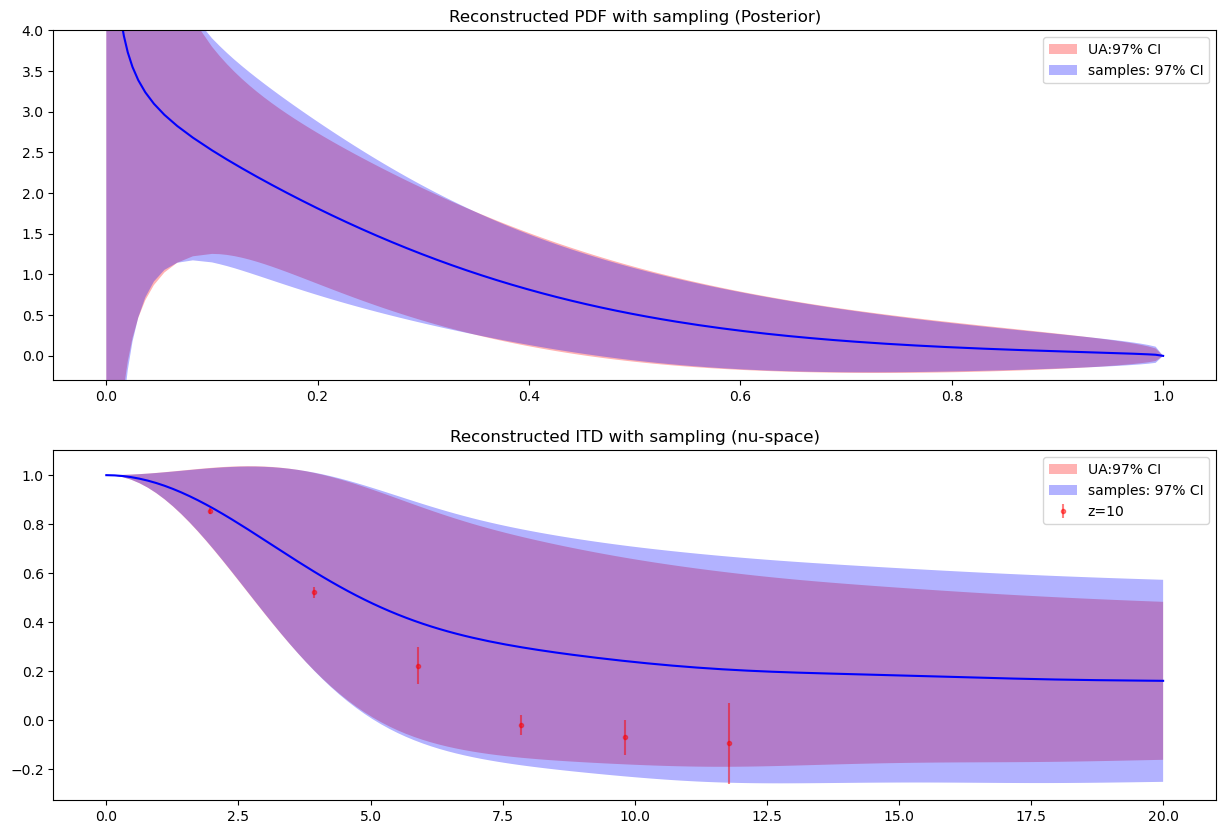

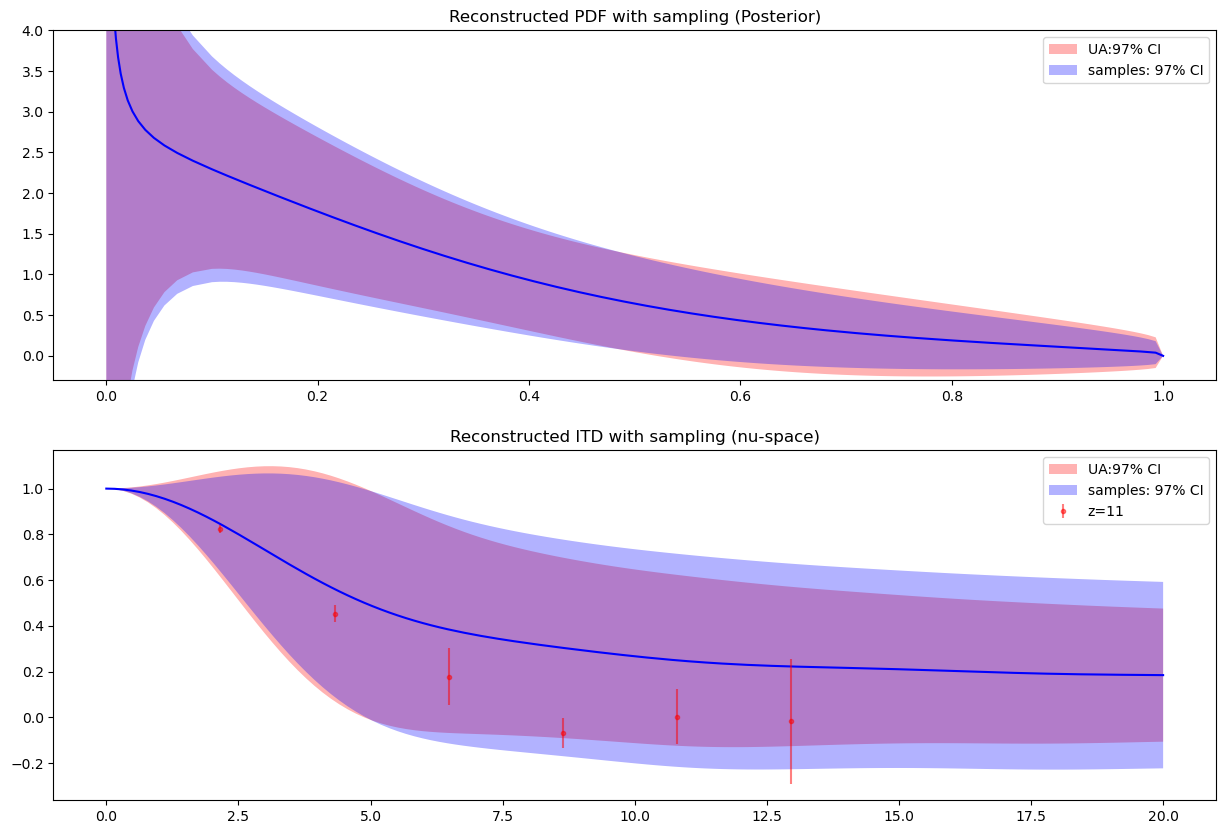

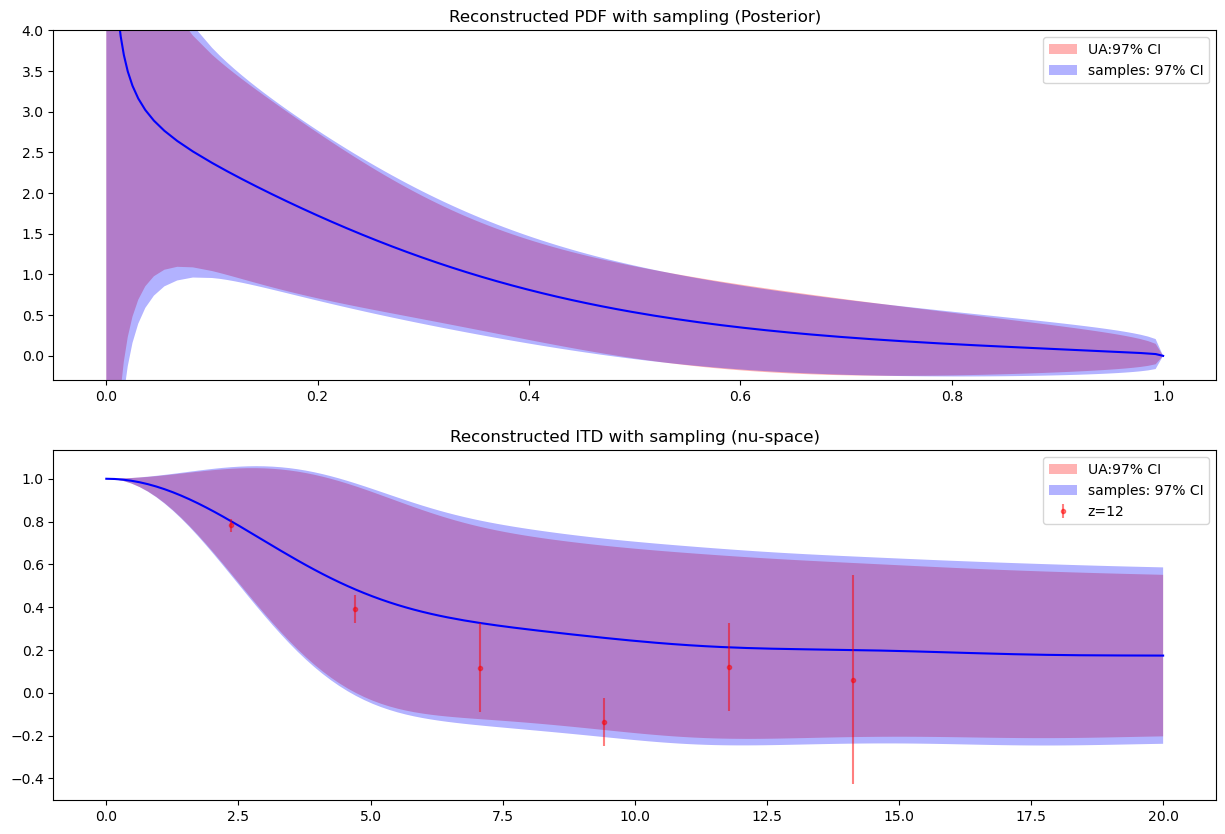

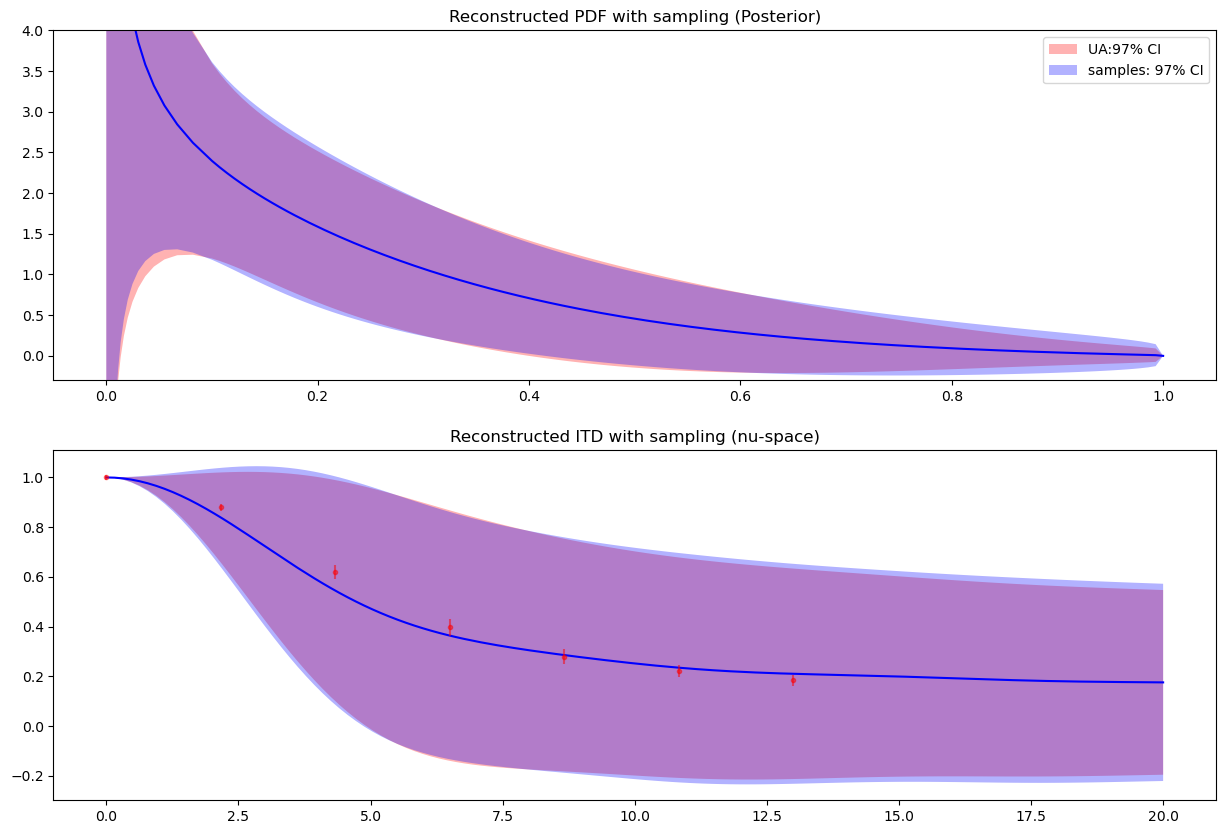

In [12]:
#plot Qnu[0]
for i in range(0,13):
    fig, ax= plt.subplots(2,figsize=(15, 10))
    ax[0].set_title("Reconstructed PDF with sampling (Posterior)")
    ax[1].set_title("Reconstructed ITD with sampling (nu-space)")

    col=['red','blue','green','pink','black','orange','purple','brown','cyan','magenta','yellow','grey','lime']
    qofx=samplesqx[i].mean(axis=0)
    qsig=1.5*np.diag(np.cov(samplesqx[i].T))**(0.5)
    qerror=1.5*np.diag(covs[i])**(0.5)
    ax[0].fill_between(x_grid, qofxs[i] - qerror, qofxs[i] + qerror, facecolor='red', alpha=0.3,label='UA:97% CI')
    qerror=1.96*np.diag(qsig)**(0.5)
    ax[0].fill_between(x_grid, qofxs[i] - qsig, qofxs[i] + qsig, facecolor='blue', alpha=0.3,label='samples: 97% CI')
    ax[0].legend()

    #for j in range(len(samplesqx[i])):
    #    ax[0].plot(x_gri0,samplesqx[i][j],color=col[i],alpha=0.03)
    #ax[0].plot(x_gri0,qofx,label=fits_comb[i].name,color='blue')
    ax[0].plot(x_gri0,qofxs[i],label=fits_comb[i].name,color='blue')

    ax[0].set_ylim([-0.3,4])

    #plot ttQ with the mean
    mttQ = Qnu[i].mean(axis=0)
    covttQ = np.corrcoef(Qnu[i].T)
    Qsig= 1.5*np.diag(np.cov(Qnu[i].T))**0.5
    Qerror=1.5*np.diag(covsnu[i])**0.5
    #ax[1].plot(nn,Qnu[i].T,color=col[i],alpha=0.05)
    #Qsig=np.diag(covQ)**(0.5)
    ax[1].fill_between(nn, mttQ - Qerror, mttQ + Qerror, facecolor="red", alpha=0.3,label='UA:97% CI')
    ax[1].fill_between(nn, mttQ - Qsig, mttQ + Qsig, facecolor="blue", alpha=0.3,label='samples: 97% CI')
    ax[1].plot(nn,mttQ,color='blue')
    if i==12:
        numock = np.linspace(0,13,7)
        jM = pseudo_data(numock,-0.3,2.9,1.0,0.02,.2,0.2,1000)
        M = np.mean(jM,axis=0)
        eM = np.std(jM,axis=0)
        
        plt.errorbar(numock,M,eM,fmt='.',alpha=0.5,label='mock data',color='red')
        break
    plt.errorbar(nu.T[i],rM.T[i],yerr=rMe.T[i],fmt='.',alpha=0.5,label='z='+str(i+1),color='red')
    plt.legend()
    plt.show()